# Libraries

In [1]:
import pandas as pd
from scipy.stats import skew,kurtosis
import matplotlib.animation as animation
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import time
from scipy.stats import norm, t
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import scipy.optimize as opt
from sklearn.linear_model import QuantileRegressor
from scipy.stats import mstats
from scipy.optimize import minimize
import pickle
pd.set_option('display.float_format', '{:.4f}'.format)
np.set_printoptions(precision=4)
random.seed(1)

# Data 

## Data Import

In [2]:
data = pd.read_csv(r"C:\Users\lollo\PycharmProjects\Python_PRJCT\Data_Selection\Open.csv")
original = data

## Data Manipulation - Linear Interpolation

In [3]:
def linear_interpolation(df):
    df = df.copy()
    for i in range(len(df)):
        for j in range(len(df.columns)):
            if pd.isna(df.iloc[i, j]):
                if i == 0:
                    df.iloc[i, j] = df.iloc[i+1, j]
                elif i == len(df) - 1:
                    df.iloc[i, j] = df.iloc[i-1, j]
                else:
                    df.iloc[i, j] = (df.iloc[i-1, j] + df.iloc[i+1, j]) / 2 
    return df
df = pd.DataFrame(data)
df.set_index('Date', inplace=True)

In [4]:
threshold = 0.1  #Run this cell to clean up the Dataset by keeping only the Stocks with less than 10% of NaN
nan_percentage = df.isna().mean()
columns_to_keep = nan_percentage[nan_percentage < threshold].index
df_cleaned = df[columns_to_keep]
df = linear_interpolation(df_cleaned)

In [5]:
chosen_stocks = [    'A2A.MI', 'AAPL', 'AMGN', 'AMP.MI', 'AMZN', 'AXP', 'BA', 
    'BMED.MI', 'CAT', 'CPR.MI', 'CRM', 'CSCO', 'CVX', 'DIS',
    'ENEL.MI', 'ENI.MI', 'G.MI', 'GOOG', 'GS', 'HD', 'HON', 'IBM', 
    'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 
    'PG', 'STLA', 'TRV', 'TSLA', 'UCG.MI', 'UNH', 'V', 'VZ', 'WBA', 'WMT']

In [6]:
chosen_stocks = [  'AAPL', 'AMZN', 'GOOG', 'IBM']

### Log - Returns

In [7]:
ret = np.log(df.iloc[:,:] / df.iloc[:,:].shift(1)).dropna()
ret = ret[chosen_stocks]
df = df.loc[ret.index, :]

In [8]:
split_index = int(0 * len(ret))   #Split Test-Train
ret_train = ret.iloc[:split_index]
ret_test = ret.iloc[split_index:]
df_train = df.iloc[:split_index][chosen_stocks]
df_test = df.iloc[split_index:][chosen_stocks]

### Tic - Toc

In [9]:
start_time = None  #Tic-Toc function functioning like MatLab one, useful to check for efficiency
def tic():
    global start_time
    start_time = time.time()
def toc():
    if start_time is None:
        raise ValueError("tic() must be called before toc()")
    elapsed_time = time.time() - start_time
    print(f"Elapsed time: {elapsed_time:.6f} seconds")
    return elapsed_time

### Single Asset Portfolios

In [10]:
num_rows = ret_test.shape[1]  
num_cols = ret_test.shape[1]  
single_asset_weights = np.zeros((num_rows, num_cols))
np.fill_diagonal(single_asset_weights, 1)
single_asset_weights[single_asset_weights == 0] = 0.00001
row_sums = single_asset_weights.sum(axis=1)
single_asset_weights /= row_sums[:, np.newaxis]

# 3 - Methodology

## Input Parameters

In [12]:
n_of_inputs = 10-len(ret.T) #X Input population can be modified as you want
number_of_generations = 10 #Z number of Generations to be performed

## Initial Population

In [13]:
alpha = np.random.uniform(0, 1, size=len(ret_train.T) )
w = np.random.dirichlet(alpha, n_of_inputs)
w = np.vstack((w,single_asset_weights))

### Target Function Parameters

In [14]:
risk_free_rate = 0.01
alpha = 0.05
lag = 1
quantiles = [0.05]
objective_types = ['max', 'min']
upper= [1]*len(ret_train.T) #Upper and Lower Bounds of the Variables
lower = [0]*len(ret_train.T) #scaling Factor
crossover_probability = 0.9
eta_crossover = 15 #For a large value of eta the Probability that solutions will be created closer to the parents is high
probability_beta = 0.5
p_m = 1/len(w.T)
eta_mutation = 20

#### 3.2.1 - Expected Returns

In [15]:
def f1(data, weights):
    """
    Calculates the annualized expected return of a portfolio based on historical data.

    Inputs:
    - data: numpy array or DataFrame
        A 2D array or pandas DataFrame where each row represents a time period (e.g., daily returns) 
        and each column represents the returns of an individual asset in the portfolio.
    - weights: numpy array
        A 1D numpy array representing the portfolio weights for each asset. The length of the array should match the number of columns in `data`.

    Outputs:
    - annualized_expected_return: float
        The annualized expected return of the portfolio.

    Steps:
    1. Calculate the mean return of each asset over the given time periods (`mu`).
    2. Compute the expected return of the portfolio by taking the dot product of the mean returns and the portfolio weights (`expected_return`).
    3. Annualize the expected return by multiplying it by 252 (assuming 252 trading days in a year).

    Returns:
    - The annualized expected return of the portfolio as a float.
    """
    mu = np.mean(data, axis=0)  
    expected_return = np.dot(mu, weights)  
    return expected_return *252  

#### 3.2.2 - Expected Shortfall

In [16]:
def calculate_ES(data, weights, lag=1, quantiles=[0.05], alpha=quantiles):
    """
    Calculates the Expected Shortfall (ES) for a given portfolio using quantile regression.

    Inputs:
    - data: DataFrame
        A pandas DataFrame where each row represents a time period, and each column represents the returns of an asset.
    - weights: numpy array
        A numpy array representing the portfolio weights for each asset. The length of the array should match the number of columns in `data`.
    - lag: int, optional (default=1)
        The number of time periods to lag when calculating the quantile predictions.
    - quantiles: list of floats, optional (default=[0.05])
        A list of quantile values to use in the quantile regression, typically containing values like 0.05 for VaR at the 5% level.
    - alpha: list of floats, optional (default=quantiles)
        A list of alpha values corresponding to the quantiles, used in the ES calculation.

    Outputs:
    - Forecasted Expected Shortfall: float64
        The calculated Expected Shortfall for the current portfolio at the specified quantile.

    Internal Functions:
    - Portfolio_returns(data, weights):
        Computes the portfolio returns by taking the dot product of the asset returns and the portfolio weights.
    - ES_t(l, prediction_0_05):
        Calculates the Expected Shortfall at time t given the lambda parameter and the VaR prediction.
    - f_yt(l, prediction_0_05, quantile_0_05, Y, alpha):
        Computes the likelihood function for the ES calculation.
    - negative_log_likelihood(l, prediction_0_05, quantile_0_05, Y, alpha):
        Computes the negative log-likelihood, which is minimized to find the optimal lambda for ES calculation.

    Steps:
    1. Calculate portfolio returns using the provided data and weights.
    2. Define intercept, max, min, and quantile features for the quantile regression model.
    3. Fit a quantile regression model and predict the VaR for the specified quantiles.
    4. Use the predictions to update the quantile feature and refit the model iteratively.
    5. Minimize the negative log-likelihood to obtain the optimal lambda parameter for ES calculation.
    6. Forecast the Expected Shortfall and Value at Risk (VaR) for the next period.
    7. Return the negative of the Current Expected Shortfall.

    Returns:
    - np.float64(-Current_Expected_Shortfall): The negative of the Expected Shortfall for the current period.
    """
    def Portfolio_returns(data, weights):
        work = np.zeros(len(data))
        for i in range(len(data)):
            work[i] = np.dot(data.iloc[i, :], weights.flatten())
        return work

    def ES_t(l, prediction_0_05):
        return (1 + np.exp(l)) * prediction_0_05

    def f_yt(l, prediction_0_05, quantile_0_05, Y, alpha):
        ES_t_val = ES_t(l, prediction_0_05)
        term1 = (1 - quantile_0_05) / ((np.mean(Y) - ES_t_val)+0.001)
        term2 = np.exp(-((Y - prediction_0_05) * (quantile_0_05 - np.minimum(Y, prediction_0_05))) / (quantile_0_05 * (np.mean(Y) - ES_t_val)))
        return term1 * term2

    def negative_log_likelihood(l, prediction_0_05, quantile_0_05, Y, alpha):
        likelihood = f_yt(l, prediction_0_05, quantile_0_05, Y, alpha)
        
        log_likelihood =( np.sum(np.log(likelihood)))
        return -log_likelihood
    
    yt = Portfolio_returns(data, weights).reshape(-1, 1)

    intercept = np.ones([len(yt) - lag, 1])
    maxx = np.maximum(yt[0:(len(yt) - lag)], 0).reshape(-1, 1)
    minn = np.minimum(yt[0:(len(yt) - lag)], 0).reshape(-1, 1)
    quantile_value = mstats.mquantiles(yt, prob=quantiles[0])[0]
    Q_t = np.full((len(yt) - lag, 1), quantile_value)
    X = np.concatenate([intercept, maxx, minn, Q_t], axis=1)
    Y = yt[lag:].flatten()

    predictions = {}
    coefficients = {}
    out_bounds_predictions = np.zeros_like(yt, dtype=np.bool_)
    
    for quantile in quantiles:
        qr = QuantileRegressor(quantile=quantiles[0], alpha=0)
        qr.fit(X, Y)
        y_pred = qr.predict(X)
        predictions[quantile] = y_pred
        coefficients[quantile] = qr.coef_

        if quantile == min(quantiles):
            out_bounds_predictions = np.logical_or(out_bounds_predictions, y_pred >= Y)
        elif quantile == max(quantiles):
            out_bounds_predictions = np.logical_or(out_bounds_predictions, y_pred <= Y)

        Q_t[1:] = y_pred[:-1].reshape(-1, 1)
        Q_t[0] = quantile_value

        X = np.concatenate([intercept, maxx, minn, Q_t], axis=1)

    # Minimizing negative log-likelihood for the ES calculation
    l_initial = np.array([0])
    predictions[quantiles[0]] = np.where(predictions[quantiles[0]] < 0, predictions[quantiles[0]], 0)#CHiedi se va bene
    result = minimize(negative_log_likelihood, l_initial, args=(predictions[quantiles[0]], quantiles[0], Y, alpha),method = 'L-BFGS-B')    
    l_opt = result.x[0]


    X_new = np.array([intercept[-1], maxx[-1], minn[-1], Q_t[-1]]).reshape(1, -1)

    next_period_predictions = {}

    for quantile in quantiles:
        next_period_prediction = qr.predict(X_new)
        next_period_predictions[quantile] = next_period_prediction[0]
    Forecasted_Expected_Shortfall = ES_t(l_opt,next_period_prediction)
    Forecasted_VaR = next_period_prediction
    Current_VaR = y_pred[-1]
    Current_Expected_Shortfall = ES_t(l_opt,Current_VaR)
    
    return  np.float64(-Current_Expected_Shortfall)#,Current_VaR

### 3.3 - Customization of NSGA-II 

#### 3.3.3 - Domination Function

In [17]:
def dominates(p, q, objective_types = ['max', 'min']):
    """
    Determines if solution `p` dominates solution `q` based on their cost values and the objective types.

    Inputs:
    - p: dictionary
        A dictionary representing solution `p`, containing a key 'cost' which is a list of cost values for each objective.
    - q: dictionary
        A dictionary representing solution `q`, containing a key 'cost' which is a list of cost values for each objective.
    - objective_types: list of strings, optional (default=['max', 'min'])
        A list of strings where each string specifies the type of objective for the corresponding index:
        - 'max' indicates the objective is to be maximized.
        - 'min' indicates the objective is to be minimized.

    Outputs:
    - dominates: boolean
        Returns `True` if solution `p` dominates solution `q`, otherwise `False`.

    Steps:
    1. Check if `p` is better than or equal to `q` in all objectives based on the specified objective types.
    2. Ensure that `p` is strictly better than `q` in at least one objective.
    3. Return `True` if both conditions are met, otherwise return `False`.
    """

    # Ensure p is better or equal to q in all objectives
    better_or_equal = all(
        (p['cost'][i] <= q['cost'][i] if objective_types[i] == 'min' else p['cost'][i] >= q['cost'][i])
        for i in range(len(p['cost']))
    )
    
    # Ensure p is better in at least one objective
    better_in_at_least_one = any(
        (p['cost'][i] < q['cost'][i] if objective_types[i] == 'min' else p['cost'][i] > q['cost'][i])
        for i in range(len(p['cost']))
    )
    
    return better_or_equal and better_in_at_least_one

#### 3.3.3 - Non Dominated Sorting

In [18]:
def non_dominated_sorting(pop): #Following the Pseudo Code given by Deb et Al
    """
    Performs non-dominated sorting on a population of solutions using the method described by Deb et al.

    Inputs:
    - pop: list of dictionaries
        A list of solutions, where each solution is represented as a dictionary. 
        Each dictionary contains a key 'cost' which holds a list of objective values for that solution.

    Outputs:
    - pop: list of dictionaries
        The input population with an additional key 'rank' added to each dictionary, indicating the non-domination rank of the solution.
    - F: list of lists
        A list where each sublist represents a Pareto front, containing the indices of solutions in that front.

    Steps:
    1. Initialize structures to track the domination set and the number of times each solution is dominated.
    2. Compare each pair of solutions to determine dominance relationships.
    3. Identify all non-dominated solutions (those not dominated by any other solution) and assign them a rank of 0.
    4. Iteratively identify and rank the remaining solutions by constructing subsequent Pareto fronts.
    5. Return the population with assigned ranks and the list of Pareto fronts.
    """
    pop_size = len(pop)

    domination_set = [[] for _ in range(pop_size)]
    dominated_count = [0 for _ in range(pop_size)]
    F = [[]]
    for i in range(pop_size):
        for j in range(i+1, pop_size):
            # Check if i dominates j
            if dominates(pop[i], pop[j],objective_types):
                domination_set[i].append(j)
                dominated_count[j] += 1
            
            # Check if j dominates i
            elif dominates(pop[j], pop[i],objective_types):
                domination_set[j].append(i)
                dominated_count[i] += 1

    # If i is not dominated at all
    for i in range(pop_size):
        if dominated_count[i] == 0:
            pop[i]['rank'] = 0
            F[0].append(i)

    k = 0

    while True:
        
        Q = []

        for i in F[k]:
            for j in domination_set[i]:
                dominated_count[j] -= 1
                if dominated_count[j] == 0:
                    pop[j]['rank'] = k + 1
                    Q.append(j)
        
        # Check if the next Pareto front is empty
        if not Q:
            break
        
        # Append the next Pareto front
        F.append(Q)

        # Increment the Pareto counter
        k += 1

    return pop, F

#### 3.3.4 - Crowding Distance

In [19]:
def CrowdingDist(pop, fronts, optimized=False):
    """
    Computes the crowding distance for each individual in the population across multiple Pareto fronts.

    Inputs:
    - pop: list of dictionaries
        A list of solutions, where each solution is represented as a dictionary. 
        Each dictionary contains a key 'cost' which holds a list of objective values for that solution.
    - fronts: list of lists
        A list where each sublist represents a Pareto front, containing the indices of solutions in that front.
    - optimized: boolean, optional (default=False)
        If True, applies an additional calculation step to further adjust the crowding distances.

    Outputs:
    - dist_indx: list of floats
        A list where each element represents the crowding distance of the corresponding solution in the population.
    """
    num_rows = len(pop)  

    dist_f = []
    dist_indx = [float("inf")] * num_rows  

    for front in fronts:
        r = len(front) 

        if r == 0:
            continue

        distances = [0.0] * r  
        F = front
        
        num_objectives = len(pop[F[0]]['cost'])

        for i in range(num_objectives):
            F_sorted = sorted(F, key=lambda x: pop[x]['cost'][i])
            distances[0] = float("inf")
            distances[-1] = float("inf")
            
            
            
            norm = float(pop[F_sorted[-1]]['cost'][i] - pop[F_sorted[0]]['cost'][i])
            if norm == 0:
                norm = 1
            
            for j in range(1, r - 1):
                distances[j] += abs(pop[F_sorted[j + 1]]['cost'][i] - pop[F_sorted[j - 1]]['cost'][i]) / norm
                #print(distances)
                dist_indx[F_sorted[j]] = distances[j]
            

        if optimized:
            for i in range(num_objectives):
                F_sorted = sorted(F, key=lambda x: pop[x]['cost'][i])
                for j in range(1, r - 1):
                    distances[j] = abs(pop[F_sorted[j + 1]]['cost'][i] - pop[F_sorted[j]]['cost'][i]) / norm
                    dist_indx[F_sorted[j]] += distances[j]
        
        dist_f.append(distances)
    
    return dist_indx

#### 3.3.5 - Tournament Selection

In [20]:
def tournament(pop, X):
    """
    Performs tournament selection on a population to generate a mating pool, sorted by rank and crowding distance.

    Inputs:
    - pop: list of dictionaries
        A list of solutions, where each solution is represented as a dictionary. 
        Each dictionary must contain the keys:
        - 'rank': The non-domination rank of the solution.
        - 'crowding_distance': The crowding distance of the solution, used for tie-breaking.
    - X: 2D numpy array
        The array of decision variables associated with the population, where each row corresponds to a solution in 'pop'.

    Outputs:
    - mating_pool: list of dictionaries
        A list of solutions selected for the mating pool, sorted by rank and crowding distance.
    - X_sorted: 2D numpy array
        The input array `X`, but sorted according to the order of solutions in the `mating_pool`.

    Steps:
    1. Create a temporary list of tuples, each containing the rank, crowding distance, and the solution itself.
    2. Sort the temporary list primarily by rank, secondarily by crowding distance, and randomly in case of ties in crowding distance.
    3. Extract the sorted solutions to form the mating pool.
    4. Generate a mapping from the new sorted order back to the original indices of the population.
    5. Reorder the decision variable array `X` based on the sorted order of the mating pool.
    6. Return the sorted mating pool and the reordered `X_sorted`.
    """
    temp = [(ind['rank'], ind['crowding_distance'], ind) for ind in pop]
    
    temp.sort(key=lambda x: (x[0], -x[1], random.random() if x[1] == x[1] else 0))
    
    mating_pool = [x[2] for x in temp]

    index_mapping = {i: pop.index(ind) for i, ind in enumerate(mating_pool)}

    sorted_indices = [index_mapping[i] for i in range(len(pop))]
    X_sorted = X[sorted_indices, :]
    
    return mating_pool, X_sorted

#### 3.3.6 - Crossover Operator

In [21]:
def beta(mu,eta,probability_beta):
    """
    Calculates the mutation parameter 'beta_i'

    Inputs:
    - mu: float
        A random variable uniformly distributed between 0 and 1.
    - eta: float
        The distribution index, controlling the shape of the mutation distribution.
    - probability_beta: float
        A threshold probability used to determine which mutation formula to apply.

    Output:
    - beta_i: float
        The calculated crossover scale - parameter

    Steps:
    1. If 'mu' is less than or equal to 'probability_beta', apply the first formula for 'beta_i'.
    2. If 'mu' is greater than 'probability_beta', apply the second formula for 'beta_i'.
    3. Return the computed 'beta_i'.
    """
    if mu <= probability_beta:
        beta_i = (2*mu)**(1/(eta+1))
    else:
        beta_i = (1/(2*(1-mu)))**(1/(eta+1))
    return beta_i

In [22]:
def Crossover_Operator(X, crossover_probability, eta, probability_beta, upper, lower):
    """
    Performs a simulated binary crossover (SBX) operation on a population of solutions.

    Inputs:
    - X: 2D numpy array
        The population matrix where each row represents an individual and each column represents a variable.
    - crossover_probability: float
        The probability of crossover occurring between pairs of individuals.
    - eta: float
        The eta_crossover declared earlier to control the shape of the crossover distribution.
    - probability_beta: float
        A threshold probability used in the `beta` function to influence the mutation spread. 
    - upper: list or numpy array
        The upper bounds for each variable in the solutions.
    - lower: list or numpy array
        The lower bounds for each variable in the solutions.

    Outputs:
    - solution: list of numpy arrays
        A list containing the new pairs of offspring generated from the crossover.
    - flattened_solution: 2D numpy array
        The new population matrix containing all offspring, with each row representing an individual.
    
    Steps:
    1. Initialize an empty list to store the solution.
    2. Convert the upper and lower bounds to numpy arrays to enable element-wise operations.
    3. Randomly select pairs of individuals for crossover, ensuring each individual is used only once.
    4. For each variable in the selected pair, decide whether to perform crossover based on `crossover_probability`.
    5. If crossover is performed, calculate new offspring using the SBX method and the `beta` function.
    6. Ensure that the offspring variables respect the upper and lower bounds.
    7. If no crossover is performed, directly swap the variables between the selected individuals.
    8. Append the new individuals to the solution list.
    9. Flatten the solution list into a 2D numpy array for easier manipulation.
    10. Return the list of offspring and the flattened array.
    """
    solution = []
    n_obj, n_var = X.shape
    upper = np.array(upper) 
    lower = np.array(lower)
    remaining_indices = list(range(n_obj))
    
    while len(remaining_indices) >= 2:
        indices = random.sample(remaining_indices, 2)
        for index in indices:
            remaining_indices.remove(index)
        
        pair = X[indices]
        
        new_individual1 = []
        new_individual2 = []
        
        for i in range(n_var):
            individual1 = pair[0][i]
            individual2 = pair[1][i]
            r = random.random()
            
            if r < crossover_probability:
                if individual1 < individual2:
                    p1, p2 = individual1, individual2
                else:
                    p1, p2 = individual2, individual1
                
    
                mu1 = random.random()
                B1 = beta(mu1, eta, probability_beta)
                x1_new = [
                    0.5 * ((1 + B1) * p1 + (1 - B1) * p2), 
                    0.5 * ((1 - B1) * p1 + (1 + B1) * p2)
                ]
                
                
                new_individual1.append(min(upper[i],max(x1_new[0],lower[i])))
                new_individual2.append(min(upper[i],max(x1_new[1],lower[i])))
                        # 
                
            else:
                new_individual1.append(min(upper[i],max(individual2,lower[i])))
                new_individual2.append(min(upper[i],max(individual1,lower[i])))
                
        
        solution.append(np.array([new_individual1, new_individual2]))
    
    flattened_solution= np.vstack(solution)
    return solution,flattened_solution

#### 3.3.7 - Mutation Operator

In [23]:
def delta(r,eta):
    """
    Calculates the mutation delta factor which determines how much a given solution should mutate.

    Inputs:
    - r: float
        A random number uniformly distributed between 0 and 1. This value is used to determine the direction and magnitude of the mutation.
    - eta: float
        The distribution index, which controls the shape and spread of the mutation. Higher values of `eta` result in smaller mutations.

    Output:
    - delta: float
        The calculated mutation value

    Steps:
    1. If `r` is less than 0.5, apply the first formula to calculate `delta`.
    2. If `r` is greater than or equal to 0.5, apply the second formula to calculate `delta`.
    3. Return the computed `delta`.
    """
    if r < 0.5:
        delta = ((2*r)**(1/(eta+1))) -1
    elif r >= 0.5:
        delta = 1-((2*(1-r))**(1/(eta+1)))
    return delta

In [24]:
def mutation(x,upper,lower):
    """
    Performs a mutation operation on an individual solution within specified bounds.

    Inputs:
    - x: float or numpy array
        The crossover value(s) of the solution (X) to be mutated.
    - upper: float or numpy array
        The upper bound(s) for the mutation. This specifies the maximum allowable value(s) after mutation.
    - lower: float or numpy array
        The lower bound(s) for the mutation. This specifies the minimum allowable value(s) after mutation.

    Output:
    - x_mutated: float or numpy array
        The mutated value(s) of the solution. The mutation will shift the original value by a certain amount within the specified bounds.

    Steps:
    1. Generate a random number between 0 and 1, which will be used to determine the direction and magnitude of the mutation.
    2. Calculate the mutation delta using the `delta` function.
    3. Apply the mutation by adjusting the original value based on the delta and the difference between the upper and lower bounds.
    4. Return the mutated value, `x_mutated`.
    """
    x_mutated = x +(upper-lower)*delta(random.random(),eta_mutation)
    return x_mutated

In [25]:
def Mutation_Operator(flattened_solution,p_m,upper,lower,eta_mutation):
    """
    Applies mutation to each variable in the population based on the mutation probability.

    Inputs:
    - flattened_solution: 2D numpy array
        The population matrix where each row represents a variable and each column represents an individual solution.
    - p_m: float
        The probability of mutation occurring for each variable.
    - upper: list or numpy array
        The upper bounds for each variable in the solutions.
    - lower: list or numpy array
        The lower bounds for each variable in the solutions.
    - eta_mutation: float
        The distribution index used to control the mutation's spread and magnitude, declared earlier.

    Output:
    - numpy array
        The mutated population matrix with the same dimensions as the input `flattened_solution`.

    Steps:
    1. Transpose `X-crossover`(flattened solutions) to process each variable separately.
    2. Initialize an empty list to store the mutated solution.
    3. For each variable, apply mutation to each individual based on the mutation probability `p_m`.
    4. Use the `mutation` function to calculate the new value if a mutation occurs.
    5. Ensure that the mutated values are within the specified bounds.
    6. Append the mutated values to the solution list.
    7. Transpose the solution list back to match the original shape.
    8. Return the mutated population matrix.
    """

    X = flattened_solution.T
    n_var, n_cases = X.shape
    solution = []
    
    for variable in range(n_var):
        variable_solution = []  
        for case in range(n_cases):
            
            r = random.random() 
            if r < p_m:
                x_mutated = mutation(X[variable][case], upper[variable], lower[variable])
                x_mutated = min(max(x_mutated,lower[variable]),upper[variable])
            else:
                x_mutated = X[variable][case]
                x_mutated = min(max(X[variable][case],lower[variable]),upper[variable])
            variable_solution.append(x_mutated) 
        solution.append(variable_solution)
    return np.array(solution).T

#### 3.3.8 - Repair Function

In [26]:
def Normalize(X):
    """
    Normalizes each feature in a 2D array X using min-max scaling followed by normalization to ensure each feature sums up to 1.

    Inputs:
    - X: 2D numpy array
    Output:
    - X_n: list of 2D numpy arrays
        A list where each element is a normalized version of the corresponding row in X, with values scaled to the range [0, 1] and normalized to sum to 1.

    Steps:
    1. Iterate over each feature (row) in X.
    2. For each feature, apply min-max scaling to normalize the values to the range [0, 1].
    3. Normalize the scaled values so that they sum to 1.
    4. Append the normalized feature to the result list.
    5. Return the list of normalized features.
    """
    X_n = []

    for x in X:
        norm = []
        x_min = np.min(x)
        x_max = np.max(x)
        for a in x:
            
            norm.append((a-x_min)/(x_max-x_min))
        
        total_sum = np.sum(norm)
        norm_arr = norm / total_sum
        X_n.append(norm_arr)
    return X_n

### 3.3.2 - Initialization

In [27]:
def  create_pop(w,ret):
    """
    Creates a population of individuals where each individual is represented by a set of weights and their corresponding costs.

    Inputs:
    - w: list of numpy arrays or lists
        Each element is a weight vector that represents an individual in the population. The length of this list determines the number of individuals.
    - ret: 2D numpy array or pandas DataFrame
        The returns data used to compute the cost for each individual. Each row represents a different time period, and each column represents different assets.

    Output:
    - population: list of dictionaries
        Each dictionary represents an individual in the population with their associated costs and rank.

    Steps:
    1. Initialize an empty list to store the population.
    2. For each weight vector in `w`, calculate the cost using two functions:
       - `f1` to compute the expected return.
       - `calculate_ES` to compute the Expected Shortfall (ES).
    3. Create a dictionary for each individual containing their costs and an initial rank of `None`.
    4. Append each dictionary to the population list.
    5. Return the population list.
    """
    population = []
    for weights in w:
        cost = [f1(ret, weights),calculate_ES(ret, weights, lag=1, quantiles=[0.05], alpha=quantiles)]
        population.append({'cost': cost, 'rank': None})
    return population

#### Figure 1: solutions divided by Pareto-Efficiency

In [28]:
ret_prova = ret[-21*36:]
df_prova =  df[-21*36:]

In [29]:
population = create_pop(w,ret_prova)
sorted_pop, fronts = non_dominated_sorting(population)
crowd_dist = CrowdingDist(population,fronts)
for i, dist in enumerate(crowd_dist):
    population[i]['crowding_distance'] = dist    
mating_pool,X_sorted = tournament(population,w) 
crossover_sol,flattened_solution = Crossover_Operator(X_sorted, crossover_probability, eta_crossover,probability_beta,upper,lower)
mutated_values = Normalize(Mutation_Operator(np.array(Normalize(flattened_solution)),p_m,upper,lower,eta_mutation))

In [30]:
ciccio = np.array(Normalize(flattened_solution))
pera = mutated_values
cross = []
mut=[]
pasticcio = []
for j in ciccio:
   cross.append([ f1(ret_prova,j),calculate_ES(ret_prova, j, lag=1, quantiles=[0.05], alpha=quantiles)])
for i in pera:
    mut.append([ f1(ret_prova,i),calculate_ES(ret_prova, i, lag=1, quantiles=[0.05], alpha=quantiles)])
for i in w:
    pasticcio.append([ f1(ret_prova,i),calculate_ES(ret_prova, i, lag=1, quantiles=[0.05], alpha=quantiles)])
cross = np.array(cross)
mut = np.array(mut)
pasticcio = np.array(pasticcio)

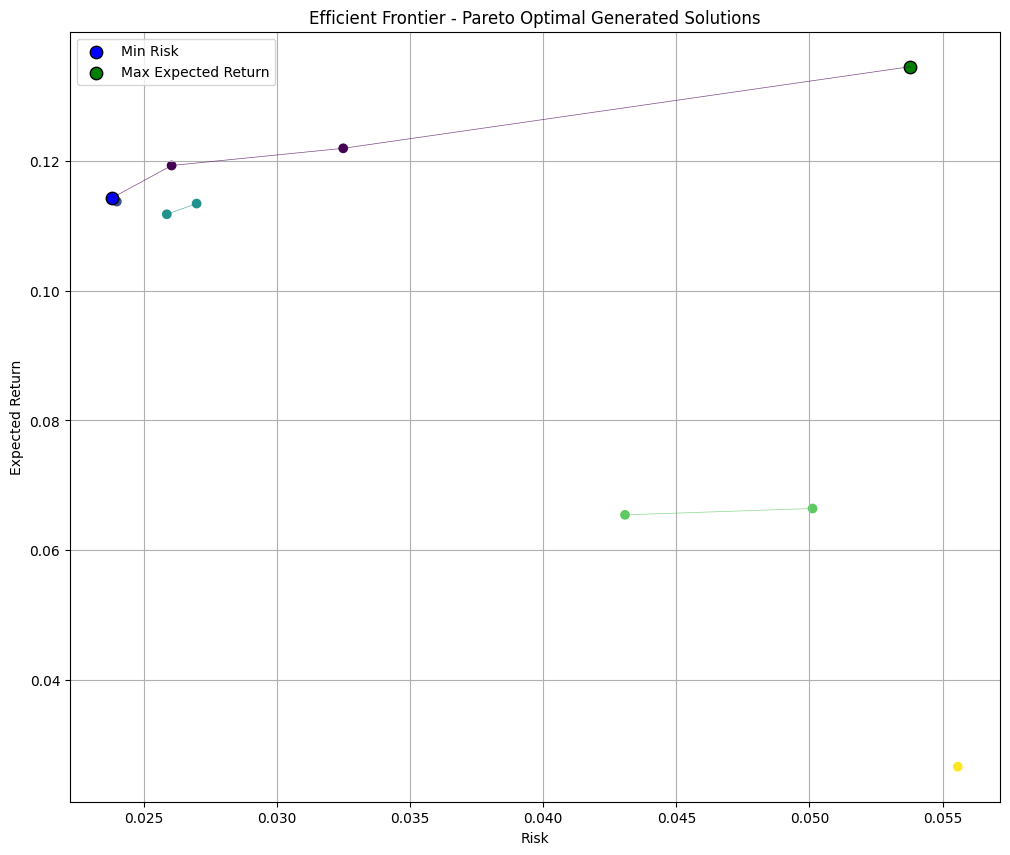

In [31]:
returns = [individual['cost'][0] for individual in sorted_pop]
risks = [individual['cost'][1] for individual in sorted_pop]
ranks = [individual['rank'] for individual in sorted_pop]
norm = plt.Normalize(min(ranks), max(ranks))
cmap = plt.get_cmap('viridis')
colors = [cmap(norm(rank)) for rank in ranks]
min_risk_idx = np.argmin(risks)
max_return_idx = np.argmax(returns)

# Highlight colors
highlight_colors = {
    'min_risk': 'blue',   
    'max_return': 'green'
}

# Plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111)

# Scatter plot for all points with risk on x-axis and return on y-axis
scatter = ax.scatter(risks, returns, c=colors, marker='o', label='_nolegend_')

# Highlight the minimum risk and maximum return points
ax.scatter(risks[min_risk_idx], returns[min_risk_idx],
           color=highlight_colors['min_risk'], s=80, edgecolor='k', label='Min Risk', alpha=1)
ax.scatter(risks[max_return_idx], returns[max_return_idx],
           color=highlight_colors['max_return'], s=80, edgecolor='k', label='Max Expected Return', alpha=1)

rank_groups = {}
for i in range(len(ranks)):
    rank = ranks[i]
    if rank not in rank_groups:
        rank_groups[rank] = {'returns': [], 'risks': []}
    rank_groups[rank]['returns'].append(returns[i])
    rank_groups[rank]['risks'].append(risks[i])

for rank, group in rank_groups.items():
    sorted_indices = np.argsort(group['risks'])
    sorted_risks = np.array(group['risks'])[sorted_indices]
    sorted_returns = np.array(group['returns'])[sorted_indices]
    ax.plot(sorted_risks, sorted_returns, color=cmap(norm(rank)), label='_nolegend_', linewidth=0.5, alpha=0.7)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

ax.set_title('Efficient Frontier - Pareto Optimal Generated Solutions')
ax.set_xlabel('Risk')
ax.set_ylabel('Expected Return')
plt.grid(True)

ax.legend()
#plt.savefig('NDS_EF.JPG', format='jpg')
plt.show()

#### Figure 2 First Iteration Results

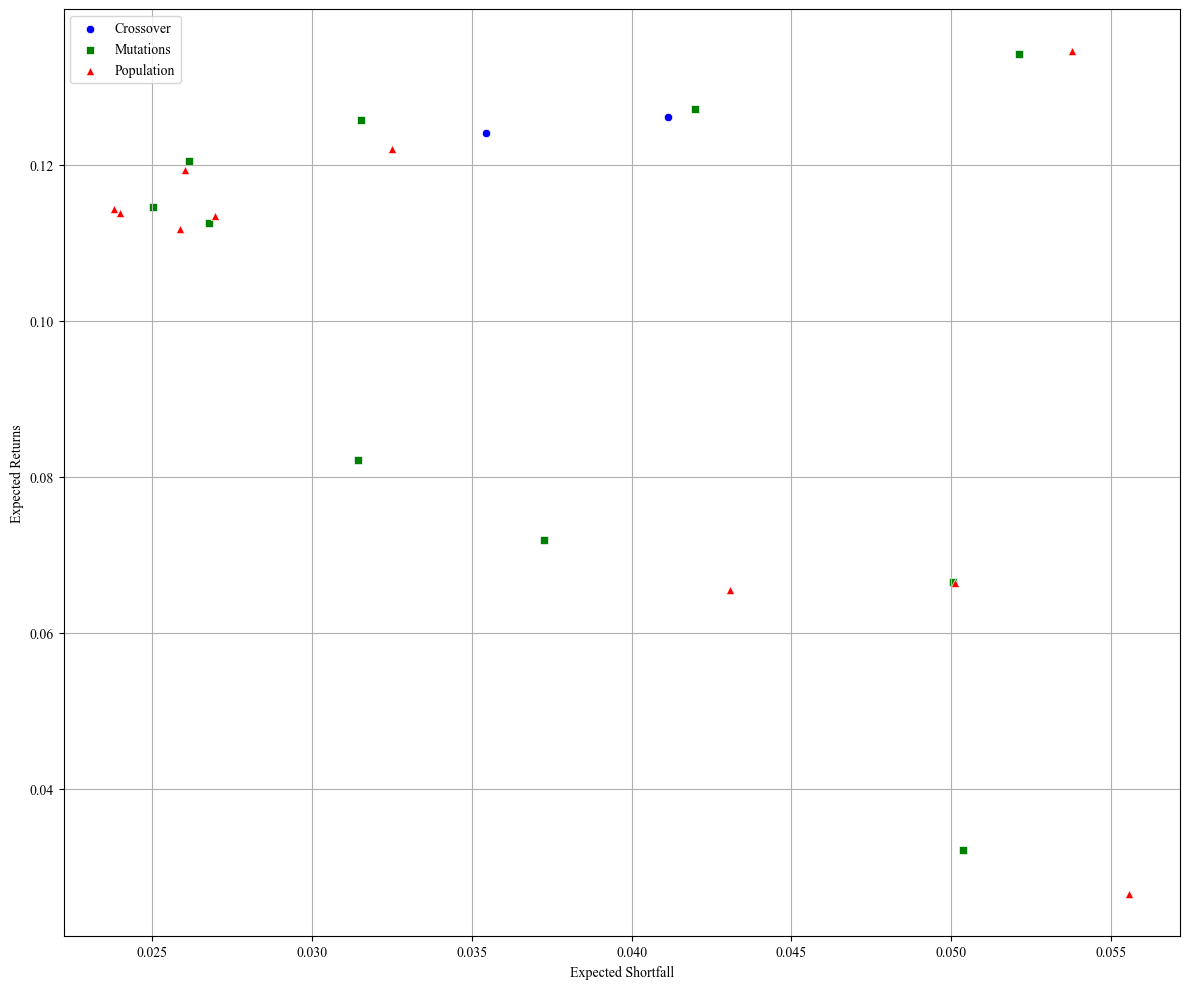

In [32]:
plt.figure(figsize=(12, 10))
plt.rcParams['font.family'] = 'Times New Roman'
sns.scatterplot(x=cross[:, 1], y=cross[:, 0], label='Crossover', color='blue', marker='o')
sns.scatterplot(x=mut[:, 1], y=mut[:, 0], label='Mutations', color='green', marker='s')
sns.scatterplot(x=pasticcio[:, 1], y=pasticcio[:, 0], label='Population', color='red', marker='^')
plt.xlabel('Expected Shortfall')
plt.ylabel('Expected Returns')
plt.legend()
plt.tight_layout()
plt.grid(True)
#plt.savefig('FG.JPG', format='jpg')
plt.show()

In [33]:
def NSGA_II(X,eta_mutation,upper,lower,crossover_probability,eta_crossover,probability_beta,p_m,number_of_generations,keep,data):
    """
    NSGA-II Core Function

    Inputs:
    - X: 2D numpy array
        Initial population matrix where each row represents an individual and each column represents different variables.
    - eta_mutation: float
        Distribution index for mutation that controls the mutation's spread and magnitude.
    - upper: list or numpy array
        Upper bounds for each variable in the solutions.
    - lower: list or numpy array
        Lower bounds for each variable in the solutions.
    - crossover_probability: float
        Probability of applying crossover to pairs of individuals.
    - eta_crossover: float
        Distribution index for crossover that controls the spread of the offspring.
    - probability_beta: float
        Parameter for the Beta distribution used in crossover.
    - p_m: float
        Probability of mutation occurring for each variable.
    - number_of_generations: int
        Number of generations to run the NSGA-II.
    - keep: float
        Proportion of the population to keep from the previous generation.
    - data: 2D numpy array or pandas DataFrame
        The returns data used to compute the costs for each individual.

    Output:
    - solution: list of 2D numpy arrays
        A list where each element is the population matrix of a generation.
    - population_history: list of lists
        A list where each element is the population of a generation, with individual dictionaries containing costs and crowding distances.
    - total: list of lists
        A list where each element is a list containing the matrix of solutions for that generation.

    Steps:
    1. Initialize the population and sort them into Pareto fronts.
    2. Compute the crowding distance for each individual.
    3. Iterate through the number of generations:
       a. Select a mating pool using tournament selection.
       b. Apply crossover to generate new solutions.
       c. Apply mutation to introduce variability.
       d. Combine parent and offspring populations and sort them into Pareto fronts.
       e. Select the next generation based on the non-dominated fronts and crowding distance.
       f. Store the population history and update the current population.
    4. Return the final solutions, population history, and the total solutions over generations.
    """
    tic()
    t = 0
    T = number_of_generations
    population = create_pop(X,data)
    solution = []
    population_history = []
    total = []
    #HV = []

    sorted_pop, fronts = non_dominated_sorting(population)
    crowd_dist = CrowdingDist(population,fronts)
    for i, dist in enumerate(crowd_dist):
        population[i]['crowding_distance'] = dist
    
    while t < T:
        
        mating_pool,X_sorted = tournament(population,X) 
        crossover_sol,flattened_solution = Crossover_Operator(X_sorted, crossover_probability, eta_crossover,probability_beta,upper,lower)
        mutated_values = Normalize(Mutation_Operator(np.array(Normalize(flattened_solution)),p_m,upper,lower,eta_mutation))
        #TEST ** Repair Function
        #mutated_values = Normalize(mutated_values)
        
        P_t = np.vstack((mutated_values, X))

        P_t_new = create_pop(P_t,data)

        
        sorted_pop, fronts = non_dominated_sorting(P_t_new)
        crowd_dist = CrowdingDist(P_t_new,fronts)
        for i, dist in enumerate(crowd_dist):
            P_t_new[i]['crowding_distance'] = dist        
        
        mating_pool,X_sorted = tournament(P_t_new,P_t)
        #print(mating_pool)
        #HV.append(hypervolume_indicator(mating_pool,reference_points))
        '''
        #print(np.mean(X_sorted,axis = 0))
        for j in range(len(X_sorted)):
            for cases in range(len(X_sorted[j])):
                print(X_sorted[j][cases])
        '''
        #print(X_sorted)
        #P_t_1 = X_sorted[:len(X),:]
        if t == 0:
            P_t_1 = X_sorted[:len(X), :]
        else:
            num_of_elem = int(len(w) * keep)
            P_t_1 = X_sorted[:num_of_elem, :]
        #print(P_t_1)
        population_history.append(mating_pool)
        total.append([X_sorted])
        
        t += 1
        print(t)
        X = P_t_1
        solution.append(X)
        toc()
        
    return solution,population_history,total

# 4 - Results

## 4.2 In Sample Analysis

In [34]:
a, b ,c= NSGA_II(w, eta_mutation, upper, lower, crossover_probability, eta_crossover, probability_beta, p_m, number_of_generations, 1, ret_prova)

1
Elapsed time: 2.097060 seconds
2
Elapsed time: 3.523217 seconds
3
Elapsed time: 4.968348 seconds
4
Elapsed time: 6.403096 seconds
5
Elapsed time: 7.906732 seconds
6
Elapsed time: 9.303808 seconds
7
Elapsed time: 10.733768 seconds
8
Elapsed time: 12.128803 seconds
9
Elapsed time: 13.591750 seconds
10
Elapsed time: 14.923882 seconds


In [35]:
costs = []
for sublist in b:
    
    for entry in sublist:
        costs.append(entry['cost'])
costs_array = np.array(costs)
returns = costs_array[:, 0]
expected_shortfall = costs_array[:, 1]
sharpe_ratios = (returns-risk_free_rate)/expected_shortfall
flattened_arrays = [np.array(arr).flatten() for arr in c]
combined_array = np.concatenate(flattened_arrays)
w_opt = combined_array.reshape(-1, len(ret.T))
jeje = w_opt[-n_of_inputs*2:]

In [36]:
ALL_weights = pd.DataFrame(jeje,columns = ret.columns)
ALL = pd.DataFrame([expected_shortfall[-n_of_inputs*2:], returns[-n_of_inputs*2:],sharpe_ratios[-n_of_inputs*2:]], index=['risk', 'ret','sharpe']).T
sorted_indices = ALL['ret'].sort_values(ascending=False).index
sorted_ALL_weights = pd.DataFrame(np.array([ALL_weights.loc[i] for i in sorted_indices]),columns = ret.columns)

### Figure 4: Efficient Portfolios Sorted by Expected Returns

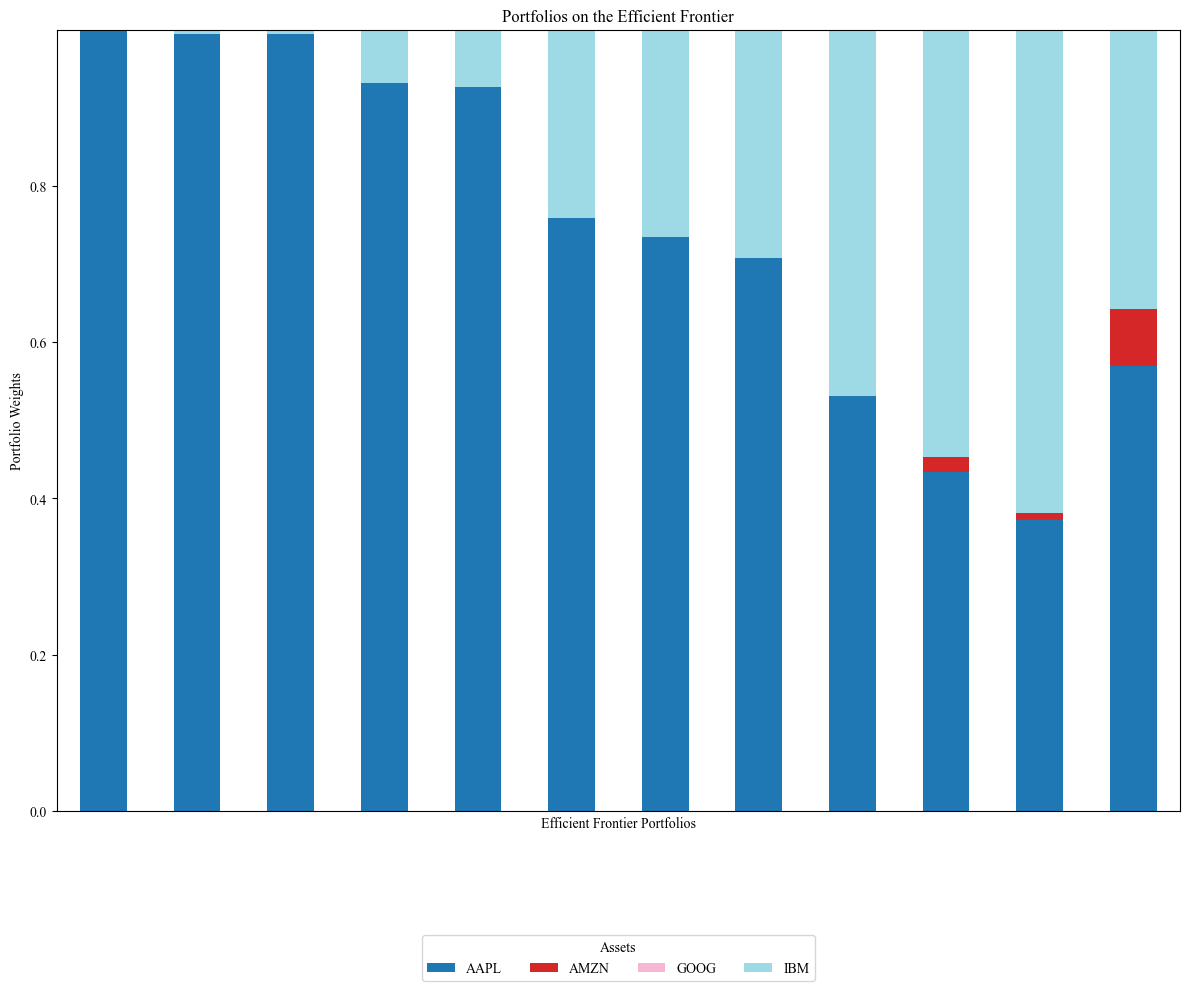

In [37]:
plt.rcParams['font.family'] = 'Times New Roman'
ax = sorted_ALL_weights.plot(kind='bar', stacked=True, figsize=(12,10), colormap='tab20')
ax.set_xlabel('Efficient Frontier Portfolios')
ax.set_ylabel('Portfolio Weights')
ax.set_title('Portfolios on the Efficient Frontier')
ax.set_xticks([])
plt.legend(title='Assets', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=9)
plt.tight_layout()
#plt.savefig('W_EF.JPG', format='jpg')
plt.show()

## 4.2.3 - NSGA-II Performance

In [38]:
def split_and_average(returns, n_of_inputs):
    subarray_size = n_of_inputs *2  #Factor to use to select the numbers of rows to include in the mean
    subarrays = np.array_split(returns, len(returns) // subarray_size)
    averages = [np.mean(subarray) for subarray in subarrays]
    return averages

### Figure 6: Average achieved values for Generation

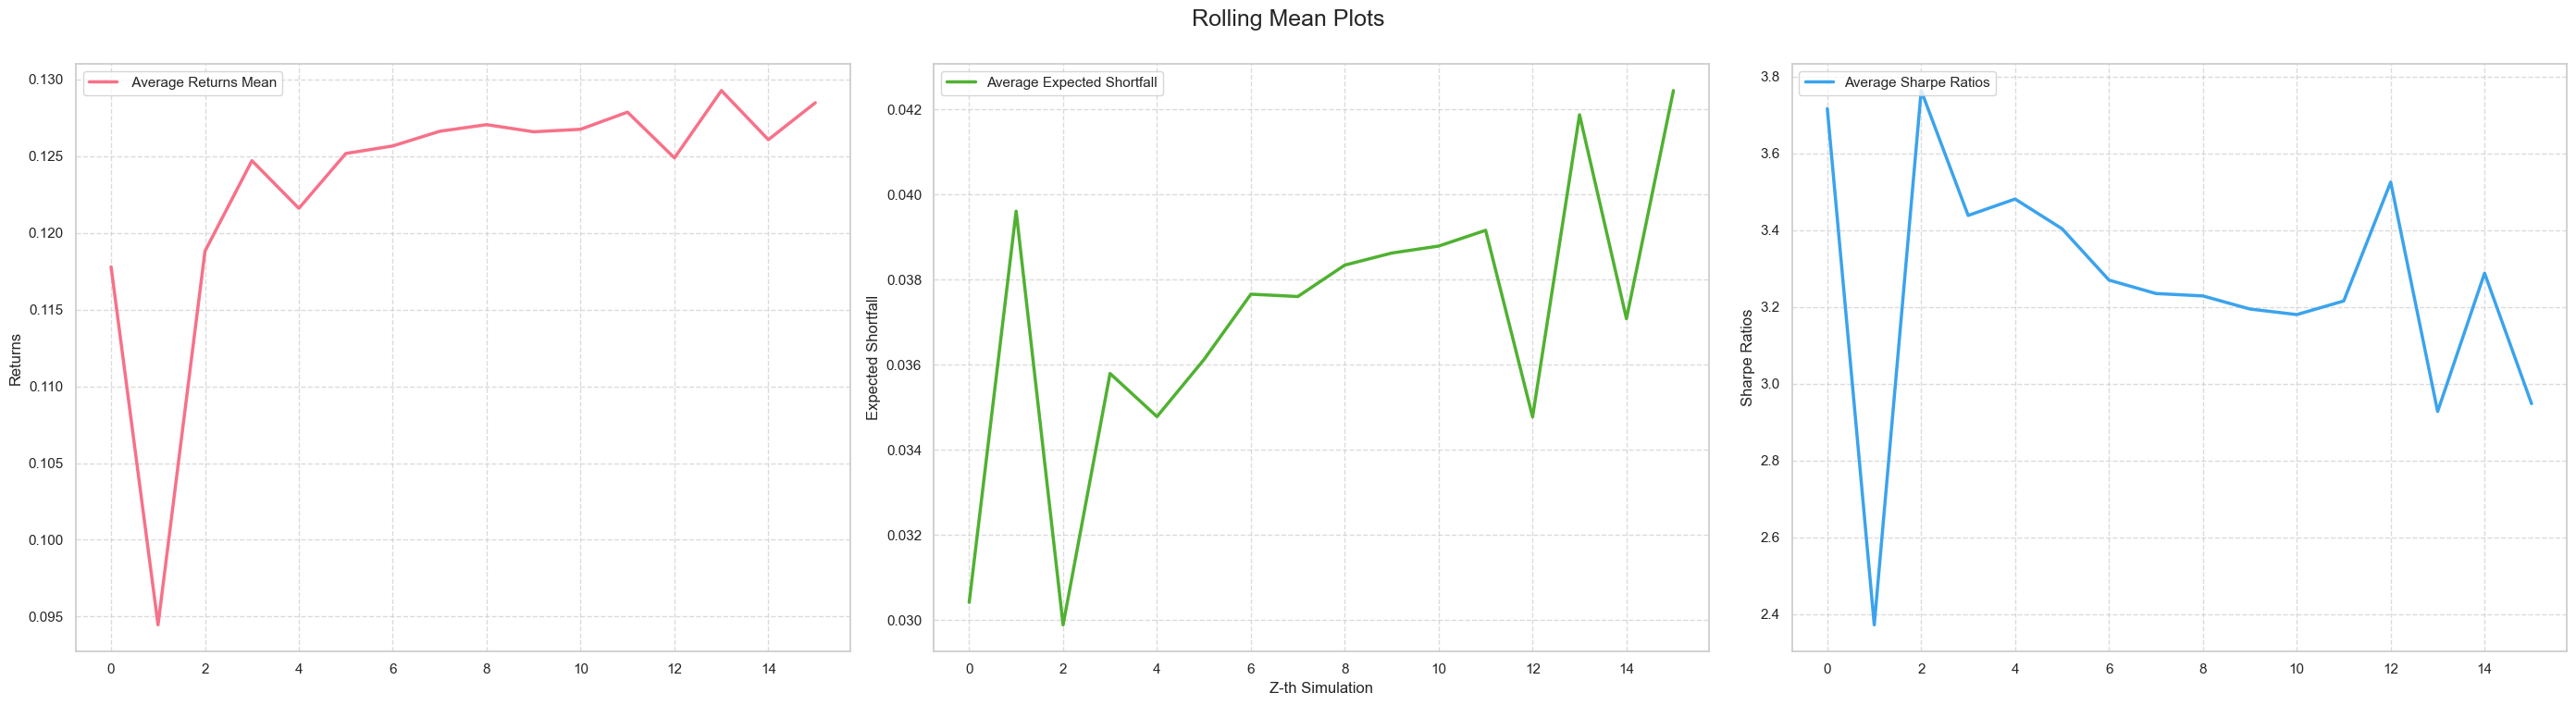

In [39]:
plt.rcParams['font.family'] = 'Times New Roman'
sns.set(style='whitegrid')

returns_rolling_mean = split_and_average(returns,n_of_inputs)
expected_shortfall_rolling_mean = split_and_average(expected_shortfall,n_of_inputs)
sharpe_ratios_rolling_mean = split_and_average(sharpe_ratios,n_of_inputs)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(28, 8))

colors = sns.color_palette("husl", 3)

axes[0].plot(returns_rolling_mean, label=' Average Returns Mean', color=colors[0], linewidth=2.5)
#axes[0].set_title(' Mean', fontsize=14)
axes[1].set_xlabel('Z-th Generation', fontsize=12)
axes[0].set_ylabel('Returns', fontsize=12)
axes[0].legend(loc='upper left')
axes[0].grid(True, linestyle='--', alpha=0.7)


axes[1].plot(expected_shortfall_rolling_mean, label='Average Expected Shortfall', color=colors[1], linewidth=2.5)
#axes[1].set_title('Expected Shortfall Rolling Mean', fontsize=14)
axes[1].set_xlabel('Z-th Simulation', fontsize=12)
axes[1].set_ylabel('Expected Shortfall', fontsize=12)
axes[1].legend(loc='upper left')
axes[1].grid(True, linestyle='--', alpha=0.7)

axes[2].plot(sharpe_ratios_rolling_mean, label='Average Sharpe Ratios', color=colors[2], linewidth=2.5)
axes[1].set_xlabel('Z-th Simulation', fontsize=12)
axes[2].set_ylabel('Sharpe Ratios', fontsize=12)
axes[2].legend(loc='upper left')
axes[2].grid(True, linestyle='--', alpha=0.7)

fig.suptitle('Rolling Mean Plots', fontsize=18, y=0.95)

plt.tight_layout(rect=[0, 0, 1, 0.95])
#plt.savefig('RRM.JPG', format='jpg')
plt.show()

#### HyperVolume Analysis

In [39]:
len(ret.T)

41

In [41]:
max_sharpe_idx = np.argmax(sharpe_ratios)
min_risk_idx = np.argmin(expected_shortfall)
max_return_idx = np.argmax(returns)
alpha_values = np.linspace(0.1, 0.7, len(expected_shortfall))
alpha_values = np.hstack((alpha_values,np.ones([n_of_inputs,])))

In [42]:
sorted_indices =(np.argsort(costs_array[:, 0]))
sorted_costs_array = costs_array[sorted_indices]
sorted_costs_array=costs_array
reference = np.array([np.min(returns),np.max(expected_shortfall),np.min(sharpe_ratios)])
aree = []
for i in range(len(sorted_costs_array[:, 0])):
    base = np.abs(reference[0] - sorted_costs_array[i, 0])
    altezza = np.abs(reference[1] - sorted_costs_array[i, 1])
    area = base * altezza
    aree.append(area)

In [43]:
def find_max_args_global(returns, n_of_inputs):
    returns = np.array(returns)
    
    max_args_global = []
    step = n_of_inputs * 2

    for i in range(0, len(returns), step):
        subarray = returns[i:i + step]
        if len(subarray) > 0:
            start_index = i
            local_max_index = np.argmax(subarray)  
            global_max_index = start_index + local_max_index
            max_args_global.append(global_max_index)
        else:
            max_args_global.append(None)  
    return max_args_global

In [44]:
max_area = np.argmax(aree)
def calcola_medie_normalizzate(aree, n_of_inputs):
    punti_per_gruppo = int(np.floor(n_of_inputs *3.375))
    medie = []
    for i in range(0, len(aree), punti_per_gruppo):
        gruppo = aree[i:i + punti_per_gruppo]
        
        if len(gruppo) == punti_per_gruppo:
            media = sum(gruppo) / len(gruppo)
            medie.append(media)
    
    if len(medie) == 0:
        return []  

    minimo = min(medie)
    massimo = max(medie)
    medie_normalizzate = [(media - minimo) / (massimo - minimo) for media in medie]
    
    return medie_normalizzate

In [48]:
len(risultato)

10

### Figure 7: Hypervolume

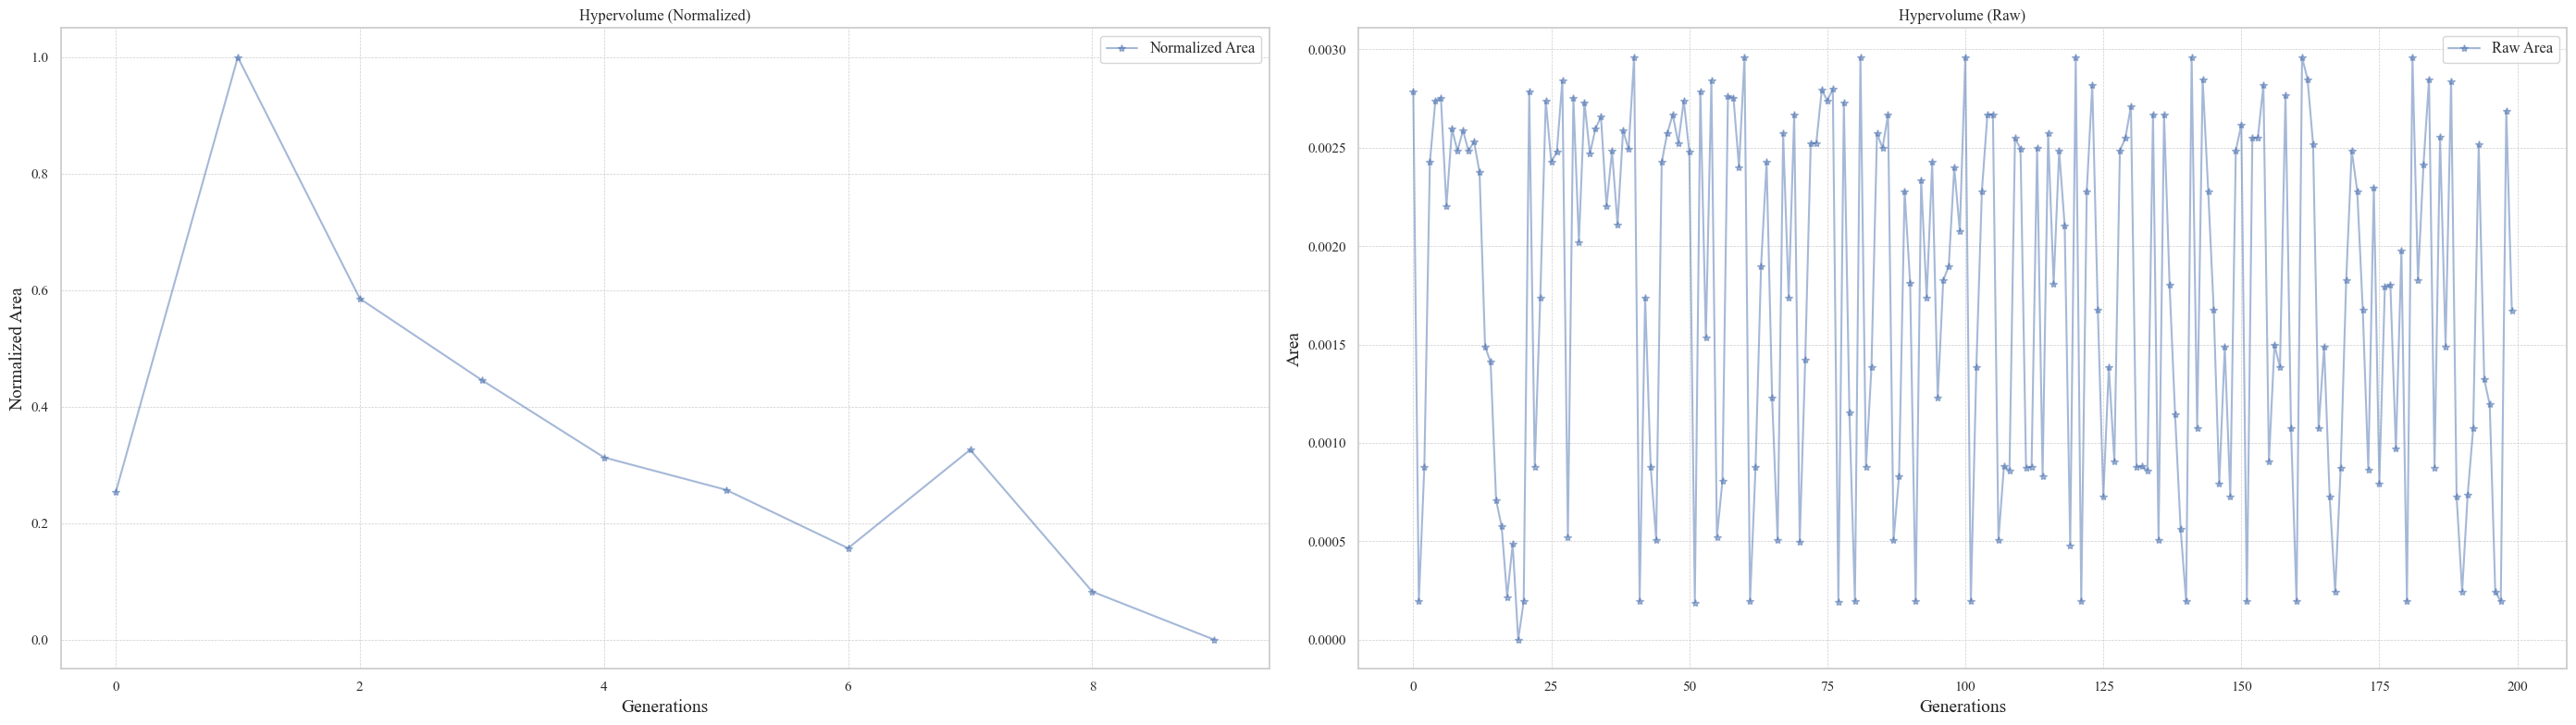

In [49]:
risultato = calcola_medie_normalizzate(aree, n_of_inputs)
fig, axs = plt.subplots(1, 2, figsize=(28, 8))  # 1 riga, 2 colonne
axs[0].plot(risultato, label='Normalized Area', marker='*', alpha=0.5)
axs[0].set_title('Hypervolume (Normalized)')
axs[0].set_xlabel('Generations', fontsize=14)
axs[0].set_ylabel('Normalized Area', fontsize=14)
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)
axs[0].legend(fontsize=12)
axs[1].plot(aree, label='Raw Area', marker='*', alpha=0.5)
axs[1].set_title('Hypervolume (Raw)')
axs[1].set_xlabel('Generations', fontsize=14)
axs[1].set_ylabel('Area', fontsize=14)
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)
axs[1].legend(fontsize=12)

plt.tight_layout()

#plt.savefig('HV.jpg', format='jpg')
plt.show()

## 4.2.2 - Efficient Frontier

In [46]:
EW = np.full(len(ret_test.T), 1/len(ret_test.T))
weights = [w_opt[max_sharpe_idx],w_opt[min_risk_idx],w_opt[max_area],w_opt[max_return_idx],EW]
portfolio_value = 1
ret_test = ret[(-21*12):]#ret_prova
x_assets=[]
y_assets = []
for j in single_asset_weights:
    x_assets.append(calculate_ES(ret_test,j, lag=1, quantiles=[0.05], alpha=quantiles))
    y_assets.append(f1(ret_test, j))
x_assets= np.array(x_assets)
y_assets = np.array(y_assets)
z_assets = (y_assets-risk_free_rate)/x_assets

In [50]:
alpha_values = alpha_values[0:len(returns)]

### Figure 3: Obtained Efficient Frontier

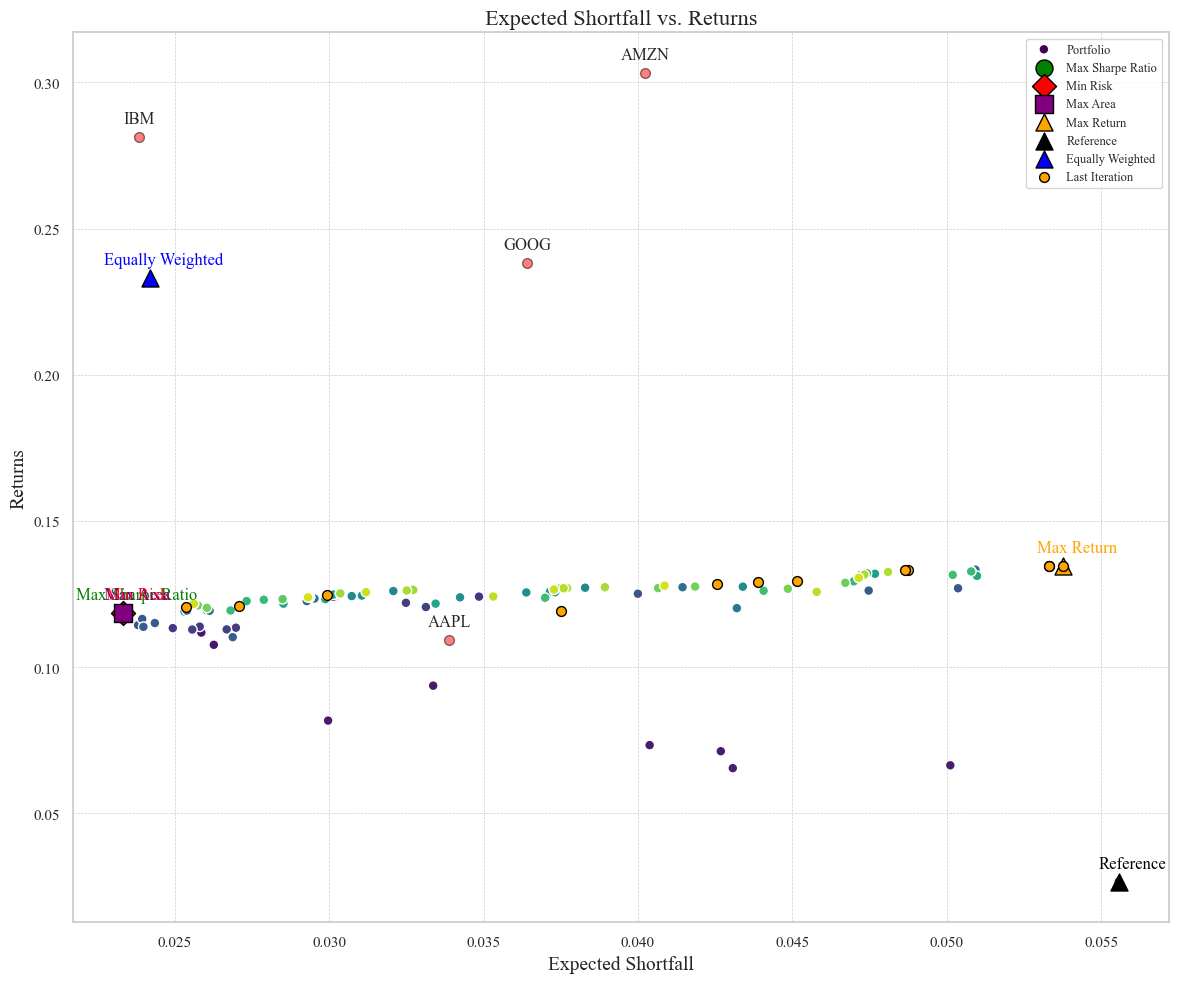

In [51]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(12, 10))

# Scatter plot dei dati
plt.scatter(expected_shortfall, returns,  label='Portfolio', edgecolors='w', s=50,c = alpha_values,cmap = 'viridis')
#plt.scatter(expected_shortfall[-n_of_inputs:], returns[-n_of_inputs:], c='cyan', label='Portfolio', edgecolors='w', s=50,alpha =0.7)
# Punti di interesse
plt.scatter(expected_shortfall[max_sharpe_idx], returns[max_sharpe_idx], color='green', label='Max Sharpe Ratio', s=150, edgecolors='black', marker='o')
plt.scatter(expected_shortfall[min_risk_idx], returns[min_risk_idx], color='red', label='Min Risk', s=150, edgecolors='black', marker='D')
plt.scatter(expected_shortfall[max_area], returns[max_area], color='purple', label='Max Area', s=150, edgecolors='black', marker='s')
plt.scatter(expected_shortfall[max_return_idx], returns[max_return_idx], color='orange', label='Max Return', s=150, edgecolors='black', marker='^')
plt.scatter(reference[1], reference[0], color='black', label='Reference', s=150, edgecolors='black', marker='^')
plt.scatter(calculate_ES(ret_test, EW, lag=1, quantiles=[0.05], alpha=quantiles),f1(ret_test,EW),label = 'Equally Weighted',color='blue',s = 150,edgecolors='black',marker='^')
plt.scatter(ALL['risk'],ALL['ret'],label = 'Last Iteration',color='orange',s = 50,edgecolors='black')
plt.scatter(x_assets, y_assets, color='red', s=50, edgecolors='black', marker='o',alpha = 0.5)

# Aggiungi le etichette sui punti
for i, txt in enumerate(ret_test.columns):
    plt.annotate(txt, (x_assets[i], y_assets[i]), textcoords="offset points", xytext=(0,10), ha='center')

#plt.scatter(calculate_ES(ret_test, hhhhh, lag=1, quantiles=[0.05], alpha=quantiles),f1(ret_test,hhhhh),label = 'Equally Weighted',color='blue',s = 150,edgecolors='black',marker='^')
# Titolo e etichette con font più grandi
plt.title('Expected Shortfall vs. Returns', fontsize=16)
plt.xlabel('Expected Shortfall', fontsize=14)
plt.ylabel('Returns', fontsize=14)
#plt.annotate('', xy=(0.037, 0.2), xytext=(0.03, 0.02),
             #arrowprops=dict(facecolor='blue', shrink=0.05, width=2, headwidth=8))
# Griglia personalizzata
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Legenda con font più grande
plt.legend(fontsize=9)

# Aggiungi annotazioni ai punti di interesse
plt.annotate('Max Sharpe Ratio', (expected_shortfall[max_sharpe_idx], returns[max_sharpe_idx]), textcoords="offset points", xytext=(10,10), ha='center', fontsize=12, color='green')
plt.annotate('Min Risk', (expected_shortfall[min_risk_idx], returns[min_risk_idx]), textcoords="offset points", xytext=(10,10), ha='center', fontsize=12, color='red')
plt.annotate('Max Area', (expected_shortfall[max_area], returns[max_area]), textcoords="offset points", xytext=(10,10), ha='center', fontsize=12, color='purple')
plt.annotate('Max Return', (expected_shortfall[max_return_idx], returns[max_return_idx]), textcoords="offset points", xytext=(10,10), ha='center', fontsize=12, color='orange')
plt.annotate('Reference',(reference[1], reference[0]),textcoords= "offset points", xytext=(10,10), ha='center', fontsize=12, color='black')
plt.annotate('Equally Weighted',(calculate_ES(ret_test, EW, lag=1, quantiles=[0.05], alpha=quantiles), f1(ret_test,EW)), textcoords= "offset points", xytext=(10,10), ha='center', fontsize=12, color='blue')
plt.tight_layout()
#plt.savefig('EF_SR.JPG', format='jpg')
plt.show()

### Figure 5: Sharpe ratio growth

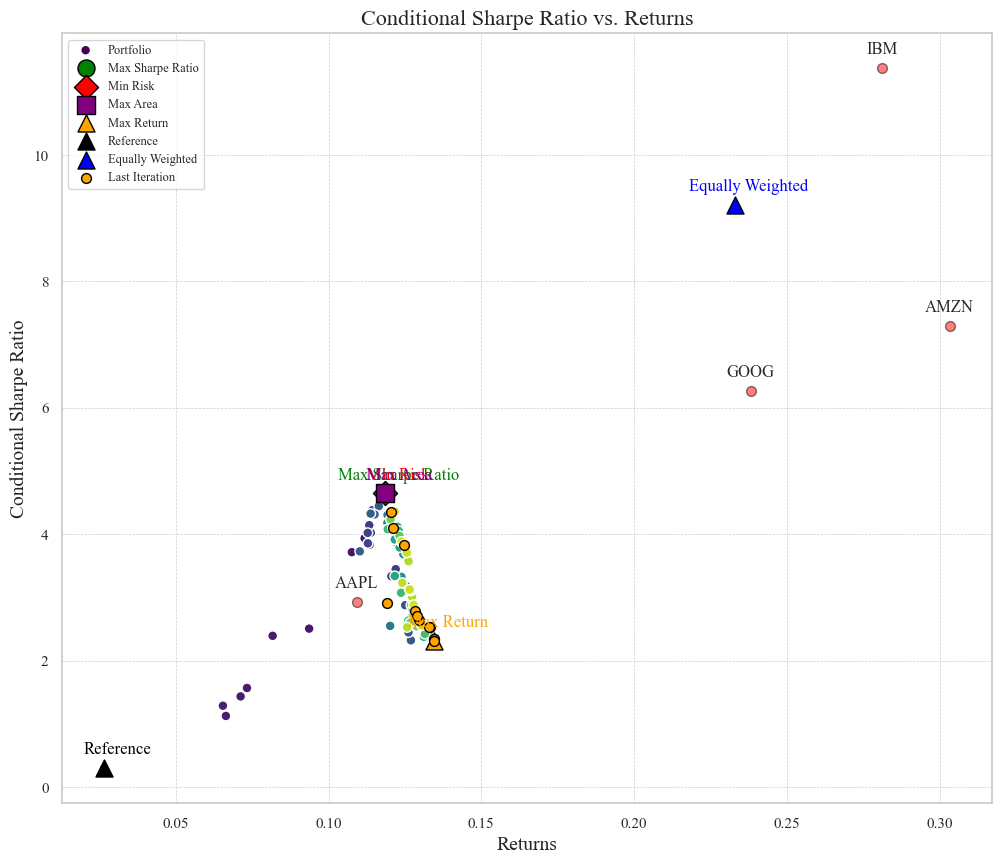

In [52]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(12, 10))

plt.scatter(returns, sharpe_ratios,  label='Portfolio', edgecolors='w', s=50,c = alpha_values,cmap = 'viridis')
#plt.scatter(expected_shortfall[-n_of_inputs:], returns[-n_of_inputs:], c='cyan', label='Portfolio', edgecolors='w', s=50,alpha =0.7)

plt.scatter(returns[max_sharpe_idx], sharpe_ratios[max_sharpe_idx], color='green', label='Max Sharpe Ratio', s=150, edgecolors='black', marker='o')
plt.scatter(returns[min_risk_idx], sharpe_ratios[min_risk_idx], color='red', label='Min Risk', s=150, edgecolors='black', marker='D')
plt.scatter(returns[max_area], sharpe_ratios[max_area], color='purple', label='Max Area', s=150, edgecolors='black', marker='s')
plt.scatter(returns[max_return_idx], sharpe_ratios[max_return_idx], color='orange', label='Max Return', s=150, edgecolors='black', marker='^')
plt.scatter(reference[0], reference[2], color='black', label='Reference', s=150, edgecolors='black', marker='^')
plt.scatter(f1(ret_test,EW),(f1(ret_test,EW)-risk_free_rate)/calculate_ES(ret_test, EW, lag=1, quantiles=[0.05], alpha=quantiles),label = 'Equally Weighted',color='blue',s = 150,edgecolors='black',marker='^')
plt.scatter(ALL['ret'],ALL['sharpe'],label = 'Last Iteration',color='orange',s = 50,edgecolors='black')
plt.scatter( y_assets,z_assets, color='red', s=50, edgecolors='black', marker='o',alpha = 0.5)
#plt.scatter(calculate_ES(ret_test, hhhhh, lag=1, quantiles=[0.05], alpha=quantiles),f1(ret_test,hhhhh),label = 'Equally Weighted',color='blue',s = 150,edgecolors='black',marker='^')
for i, txt in enumerate(ret_test.columns):
    plt.annotate(txt, (y_assets[i], z_assets[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Conditional Sharpe Ratio vs. Returns', fontsize=16)
plt.xlabel('Returns', fontsize=14)
plt.ylabel('Conditional Sharpe Ratio', fontsize=14)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.legend(fontsize=9)

plt.annotate('Max Sharpe Ratio', (returns[max_sharpe_idx], sharpe_ratios[max_sharpe_idx]), textcoords="offset points", xytext=(10,10), ha='center', fontsize=12, color='green')
plt.annotate('Min Risk', (returns[min_risk_idx], sharpe_ratios[min_risk_idx]), textcoords="offset points", xytext=(10,10), ha='center', fontsize=12, color='red')
plt.annotate('Max Area', (returns[max_area], sharpe_ratios[max_area]), textcoords="offset points", xytext=(10,10), ha='center', fontsize=12, color='purple')
plt.annotate('Max Return', (returns[max_return_idx], sharpe_ratios[max_return_idx]), textcoords="offset points", xytext=(10,10), ha='center', fontsize=12, color='orange')
plt.annotate('Reference',(reference[0], reference[2]),textcoords= "offset points", xytext=(10,10), ha='center', fontsize=12, color='black')
#plt.annotate('Equally Weighted',f1(ret_test,EW), f1(ret_test,EW)), textcoords= "offset points", xytext=(10,10), ha='center', fontsize=12, color='blue')
plt.annotate(
    'Equally Weighted',
    xy=(f1(ret_test, EW), (f1(ret_test, EW) - risk_free_rate) / calculate_ES(ret_test, EW, lag=1, quantiles=[0.05], alpha=quantiles)),
    textcoords="offset points",
    xytext=(10, 10),
    ha='center',
    fontsize=12,
    color='blue'
)

#plt.savefig('CSR_R.JPG', format='jpg')
plt.show()

## 4.2.1 - Portfolios Composition

### Figure 10: Optimal Portfolios

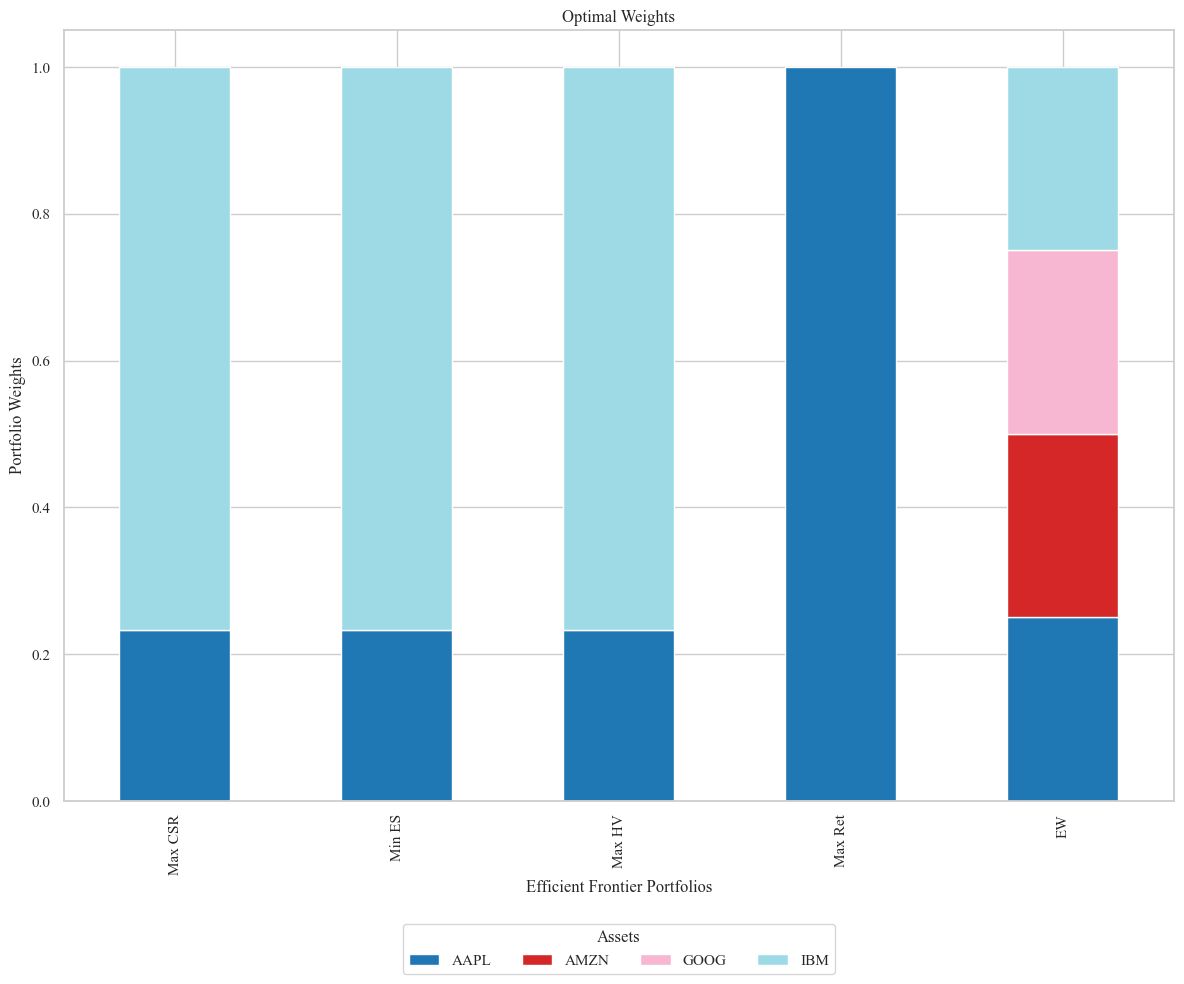

In [53]:
pesi = pd.DataFrame(weights,columns = ret.columns,index = ['Max CSR','Min ES','Max HV','Max Ret','EW'])
plt.rcParams['font.family'] = 'Times New Roman'
ax = pesi.plot(kind='bar', stacked=True, figsize=(12,10), colormap='tab20')

ax.set_xlabel('Efficient Frontier Portfolios')
ax.set_ylabel('Portfolio Weights')
ax.set_title('Optimal Weights')
#ax.set_xticks(['Max CSR','Min ES','Max HV','Max Ret','EW'])
plt.legend(title='Assets', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=9)
plt.tight_layout()
#plt.savefig('pipo.JPG', format='jpg')

plt.show()

#### Herfindahl-Hirschman Index

In [54]:
HHI = []
for j in weights:
    HHI.append(np.sum(j**2))
HHI= np.array(HHI)

#### Number of Stocks

In [55]:
rounded_weights = (np.round(weights,4))
non_zero_counts = np.sum(rounded_weights != 0,axis =1)
#pd.DataFrame([non_zero_counts,HHI],columns = ['Max Sharpe','Min RIsk','Max Area','Max Ret','EW'],index = ['Number of Stocks','HHI'])

#### Jaccard Index

In [56]:
def jaccard_index(subarray1, subarray2):
    set1 = set(np.nonzero(subarray1)[0])
    set2 = set(np.nonzero(subarray2)[0])
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union != 0 else 0

In [57]:
def compute_jaccard_indices(weights):
    n = len(weights)
    jaccard_indices = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i+1, n):
            index = jaccard_index(weights[i], weights[j])
            jaccard_indices[i, j] = index
            jaccard_indices[j, i] = index
    
    return jaccard_indices

#### Table 1

In [58]:
jaccard_indices = pd.DataFrame(np.tril(compute_jaccard_indices(weights)), index = ['Max Sharpe','Min RIsk','Max Area','Max Ret','EW'],columns = ['Max Sharpe','Min RIsk','Max Area','Max Ret','EW'])

In [59]:
jaccard_indices

,Max Sharpe,Min RIsk,Max Area,Max Ret,EW
Max Sharpe,0.0000,0.0000,0.0000,0.0000,0.0000
Min RIsk,1.0000,0.0000,0.0000,0.0000,0.0000
Max Area,1.0000,1.0000,0.0000,0.0000,0.0000
Max Ret,0.5000,0.5000,0.5000,0.0000,0.0000
EW,0.5000,0.5000,0.5000,0.2500,0.0000


## 4.3 Robustness Testing - Annual Optimisation

In [60]:
ret_train = ret[-21*12:]

In [63]:
#tic()
a, b ,c= NSGA_II(w, eta_mutation, upper, lower, crossover_probability, eta_crossover, probability_beta, p_m, number_of_generations, 1, ret_train)
costs = []
for sublist in b:
    
    for entry in sublist:
        costs.append(entry['cost'])
costs_array = np.array(costs)
returns = costs_array[:, 0]
expected_shortfall = costs_array[:, 1]
sharpe_ratios = (returns-risk_free_rate)/expected_shortfall
flattened_arrays = [np.array(arr).flatten() for arr in c]
combined_array = np.concatenate(flattened_arrays)
w_opt = combined_array.reshape(-1, len(ret.T))
jeje = w_opt[-n_of_inputs*2:]
#toc()
max_sharpe_idx = np.argmax(sharpe_ratios)
min_risk_idx = np.argmin(expected_shortfall)
max_return_idx = np.argmax(returns)
sorted_indices =(np.argsort(costs_array[:, 0]))
sorted_costs_array = costs_array[sorted_indices]
sorted_costs_array=costs_array
reference = np.array([np.min(returns),np.max(expected_shortfall),np.min(sharpe_ratios)])
aree = []
for i in range(len(sorted_costs_array[:, 0])):
    base = np.abs(reference[0] - sorted_costs_array[i, 0])
    altezza = np.abs(reference[1] - sorted_costs_array[i, 1])
    area = base * altezza
    aree.append(area)
max_area = np.argmax(aree)
weights = [w_opt[max_sharpe_idx],w_opt[min_risk_idx],w_opt[max_area],w_opt[max_return_idx],EW]

1
Elapsed time: 0.727633 seconds
2
Elapsed time: 1.172765 seconds
3
Elapsed time: 1.609941 seconds
4
Elapsed time: 2.053838 seconds
5
Elapsed time: 2.538682 seconds
6
Elapsed time: 2.990350 seconds
7
Elapsed time: 3.442963 seconds
8
Elapsed time: 3.905617 seconds
9
Elapsed time: 4.357964 seconds
10
Elapsed time: 4.788955 seconds


In [64]:
def bootstrap_sample(data, n_samples):
    """Generates a bootstrap sample from the given data."""
    return data.sample(n=n_samples, replace=True)

# Number of bootstrap samples
n_bootstraps = 10

# Paths for saving progress
progress_path = "bootstrap_progress_big_off.pkl"
results_path = "bootstrap_results_big_off.pkl"


if os.path.exists(progress_path):
    with open(progress_path, 'rb') as f:
        current_iteration, bootstrapped_samples = pickle.load(f)
else:
    current_iteration = 0
    bootstrapped_samples = [bootstrap_sample(ret_train, len(ret_train)) for _ in range(n_bootstraps)]

if os.path.exists(results_path):
    with open(results_path, 'rb') as f:
        bootstrapped_max_sharpe_no_replacement, bootstrapped_max_ret_no_replacement, bootstrapped_min_risk_no_replacement, bootstrapped_max_area_no_replacement = pickle.load(f)
else:
    bootstrapped_max_sharpe_no_replacement = []
    bootstrapped_max_ret_no_replacement = []
    bootstrapped_min_risk_no_replacement = []
    bootstrapped_max_area_no_replacement = []

for i in range(current_iteration, n_bootstraps):
    target = bootstrapped_samples[i]
    
    tic()  # Ensure tic() and toc() are defined or imported
    a, b, c = NSGA_II(w, eta_mutation, upper, lower, crossover_probability, eta_crossover, probability_beta, p_m, number_of_generations, 1, target)
    
    costs = []
    for sublist in b:
        for entry in sublist:
            costs.append(entry['cost'])
    costs_array = np.array(costs)
    returns = costs_array[:, 0]
    expected_shortfall = costs_array[:, 1]
    sharpe_ratios = (returns - risk_free_rate) / expected_shortfall
    sorted_indices = np.argsort(costs_array[:, 0])
    sorted_costs_array = costs_array[sorted_indices]
    
    reference = np.array([np.min(returns), np.max(expected_shortfall), np.min(sharpe_ratios)])
    aree = []
    for j in range(len(sorted_costs_array[:, 0])):
        base = np.abs(reference[0] - sorted_costs_array[j, 0])
        altezza = np.abs(reference[1] - sorted_costs_array[j, 1])
        area = base * altezza
        aree.append(area)
    max_area = np.argmax(aree)

    flattened_arrays = [np.array(arr).flatten() for arr in c]
    combined_array = np.concatenate(flattened_arrays)
    w_opt_boot = combined_array.reshape(-1, len(ret.T))
    max_sharpe_idxboot = np.argmax(sharpe_ratios)
    min_risk_idx_boot = np.argmin(expected_shortfall)
    max_return_idx_boot = np.argmax(returns)

    boot_strapped_max_sharpe = w_opt_boot[max_sharpe_idxboot]
    boot_strapped_max_ret = w_opt_boot[max_return_idx_boot]
    boot_strapped_min_risk = w_opt_boot[min_risk_idx_boot]
    boot_strapped_max_area = w_opt_boot[max_area]

    bootstrapped_max_sharpe_no_replacement.append(boot_strapped_max_sharpe)
    bootstrapped_max_ret_no_replacement.append(boot_strapped_max_ret)
    bootstrapped_min_risk_no_replacement.append(boot_strapped_min_risk)
    bootstrapped_max_area_no_replacement.append(boot_strapped_max_area)
    
    toc()  # Ensure tic() and toc() are defined or imported
    
    with open(progress_path, 'wb') as f:
        pickle.dump((i + 1, bootstrapped_samples), f)
    with open(results_path, 'wb') as f:
        pickle.dump((bootstrapped_max_sharpe_no_replacement, bootstrapped_max_ret_no_replacement, bootstrapped_min_risk_no_replacement, bootstrapped_max_area_no_replacement), f)

if os.path.exists(progress_path):
    os.remove(progress_path)

C:\Users\lollo\AppData\Local\Temp\ipykernel_46172\1844539982.py:61: RuntimeWarning: invalid value encountered in log
  log_likelihood =( np.sum(np.log(likelihood)))
C:\Users\lollo\AppData\Local\Temp\ipykernel_46172\1844539982.py:55: RuntimeWarning: overflow encountered in exp
  term2 = np.exp(-((Y - prediction_0_05) * (quantile_0_05 - np.minimum(Y, prediction_0_05))) / (quantile_0_05 * (np.mean(Y) - ES_t_val)))
C:\Users\lollo\PycharmProjects\Dissertation\venv\lib\site-packages\scipy\optimize\_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
C:\Users\lollo\AppData\Local\Temp\ipykernel_46172\1844539982.py:61: RuntimeWarning: invalid value encountered in log
  log_likelihood =( np.sum(np.log(likelihood)))
C:\Users\lollo\AppData\Local\Temp\ipykernel_46172\1844539982.py:55: RuntimeWarning: overflow encountered in exp
  term2 = np.exp(-((Y - prediction_0_05) * (quantile_0_05 - np.minimum(Y, prediction_0_05))) / (quantile_0_05 * (np.mean(Y) - ES_t_val)

1
Elapsed time: 3.898486 seconds


C:\Users\lollo\AppData\Local\Temp\ipykernel_46172\1844539982.py:61: RuntimeWarning: divide by zero encountered in log
  log_likelihood =( np.sum(np.log(likelihood)))
C:\Users\lollo\PycharmProjects\Dissertation\venv\lib\site-packages\scipy\optimize\_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
C:\Users\lollo\AppData\Local\Temp\ipykernel_46172\1844539982.py:55: RuntimeWarning: overflow encountered in exp
  term2 = np.exp(-((Y - prediction_0_05) * (quantile_0_05 - np.minimum(Y, prediction_0_05))) / (quantile_0_05 * (np.mean(Y) - ES_t_val)))
C:\Users\lollo\AppData\Local\Temp\ipykernel_46172\1844539982.py:61: RuntimeWarning: invalid value encountered in log
  log_likelihood =( np.sum(np.log(likelihood)))
C:\Users\lollo\AppData\Local\Temp\ipykernel_46172\1844539982.py:55: RuntimeWarning: overflow encountered in exp
  term2 = np.exp(-((Y - prediction_0_05) * (quantile_0_05 - np.minimum(Y, prediction_0_05))) / (quantile_0_05 * (np.mean(Y) - ES_t_val

2
Elapsed time: 6.444149 seconds


C:\Users\lollo\AppData\Local\Temp\ipykernel_46172\1844539982.py:55: RuntimeWarning: overflow encountered in exp
  term2 = np.exp(-((Y - prediction_0_05) * (quantile_0_05 - np.minimum(Y, prediction_0_05))) / (quantile_0_05 * (np.mean(Y) - ES_t_val)))
C:\Users\lollo\PycharmProjects\Dissertation\venv\lib\site-packages\scipy\optimize\_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
C:\Users\lollo\AppData\Local\Temp\ipykernel_46172\1844539982.py:61: RuntimeWarning: divide by zero encountered in log
  log_likelihood =( np.sum(np.log(likelihood)))
C:\Users\lollo\AppData\Local\Temp\ipykernel_46172\1844539982.py:61: RuntimeWarning: invalid value encountered in log
  log_likelihood =( np.sum(np.log(likelihood)))
C:\Users\lollo\AppData\Local\Temp\ipykernel_46172\1844539982.py:61: RuntimeWarning: invalid value encountered in log
  log_likelihood =( np.sum(np.log(likelihood)))
C:\Users\lollo\AppData\Local\Temp\ipykernel_46172\1844539982.py:61: RuntimeWarnin

3
Elapsed time: 8.996792 seconds
Elapsed time: 8.996792 seconds
1
Elapsed time: 3.799881 seconds
2
Elapsed time: 6.379356 seconds
3
Elapsed time: 8.862408 seconds
Elapsed time: 8.862408 seconds


C:\Users\lollo\AppData\Local\Temp\ipykernel_46172\1844539982.py:61: RuntimeWarning: invalid value encountered in log
  log_likelihood =( np.sum(np.log(likelihood)))


1
Elapsed time: 3.655788 seconds
2
Elapsed time: 6.110001 seconds
3
Elapsed time: 8.843431 seconds
Elapsed time: 8.845426 seconds
1
Elapsed time: 3.963340 seconds
2
Elapsed time: 6.650008 seconds
3
Elapsed time: 9.164673 seconds
Elapsed time: 9.171125 seconds


C:\Users\lollo\AppData\Local\Temp\ipykernel_46172\1844539982.py:61: RuntimeWarning: invalid value encountered in log
  log_likelihood =( np.sum(np.log(likelihood)))
C:\Users\lollo\AppData\Local\Temp\ipykernel_46172\1844539982.py:61: RuntimeWarning: invalid value encountered in log
  log_likelihood =( np.sum(np.log(likelihood)))
C:\Users\lollo\AppData\Local\Temp\ipykernel_46172\1844539982.py:61: RuntimeWarning: invalid value encountered in log
  log_likelihood =( np.sum(np.log(likelihood)))
C:\Users\lollo\AppData\Local\Temp\ipykernel_46172\1844539982.py:61: RuntimeWarning: invalid value encountered in log
  log_likelihood =( np.sum(np.log(likelihood)))
C:\Users\lollo\AppData\Local\Temp\ipykernel_46172\1844539982.py:61: RuntimeWarning: invalid value encountered in log
  log_likelihood =( np.sum(np.log(likelihood)))
C:\Users\lollo\AppData\Local\Temp\ipykernel_46172\1844539982.py:61: RuntimeWarning: invalid value encountered in log
  log_likelihood =( np.sum(np.log(likelihood)))


1
Elapsed time: 3.739294 seconds
2
Elapsed time: 6.221497 seconds
3
Elapsed time: 8.617718 seconds
Elapsed time: 8.619711 seconds


C:\Users\lollo\AppData\Local\Temp\ipykernel_46172\1844539982.py:61: RuntimeWarning: invalid value encountered in log
  log_likelihood =( np.sum(np.log(likelihood)))
C:\Users\lollo\AppData\Local\Temp\ipykernel_46172\1844539982.py:61: RuntimeWarning: invalid value encountered in log
  log_likelihood =( np.sum(np.log(likelihood)))
C:\Users\lollo\AppData\Local\Temp\ipykernel_46172\1844539982.py:61: RuntimeWarning: invalid value encountered in log
  log_likelihood =( np.sum(np.log(likelihood)))
C:\Users\lollo\AppData\Local\Temp\ipykernel_46172\1844539982.py:61: RuntimeWarning: invalid value encountered in log
  log_likelihood =( np.sum(np.log(likelihood)))


KeyboardInterrupt: 

In [65]:
x_assets=[]
y_assets = []
for j in single_asset_weights:
    x_assets.append(calculate_ES(ret_train,j, lag=1, quantiles=[0.05], alpha=quantiles))
    y_assets.append(f1(ret_train, j))
x_assets= np.array(x_assets)
y_assets = np.array(y_assets)
z_assets = (y_assets-risk_free_rate)/x_assets
BS_SR = bootstrapped_min_risk_no_replacement
weights = np.array(weights)
ppp = []
for j in BS_SR:
    ppp.append([calculate_ES(ret_train, j, lag=1, quantiles=[0.05], alpha=quantiles),f1(ret_train, j)])
ppp.append([calculate_ES(ret_train, weights[1], lag=1, quantiles=[0.05], alpha=quantiles),f1(ret_train, weights[0])])

ppp = np.array(ppp)
x = ppp[:, 0]
y = ppp[:, 1]
z = (((np.array(ppp)[:,1]-risk_free_rate)/(np.array(ppp)[:,0])))
#CS_SR = np.concatenate((BS_SR, pesi_associati), axis=0)
RS = np.array(pd.DataFrame(BS_SR).mean())
MV_S_P = [f1(ret_train,RS) , calculate_ES(ret_train, RS, lag=1, quantiles=[0.05], alpha=quantiles)]

### Figure 8: Bootstrapped suboptimal portfolios

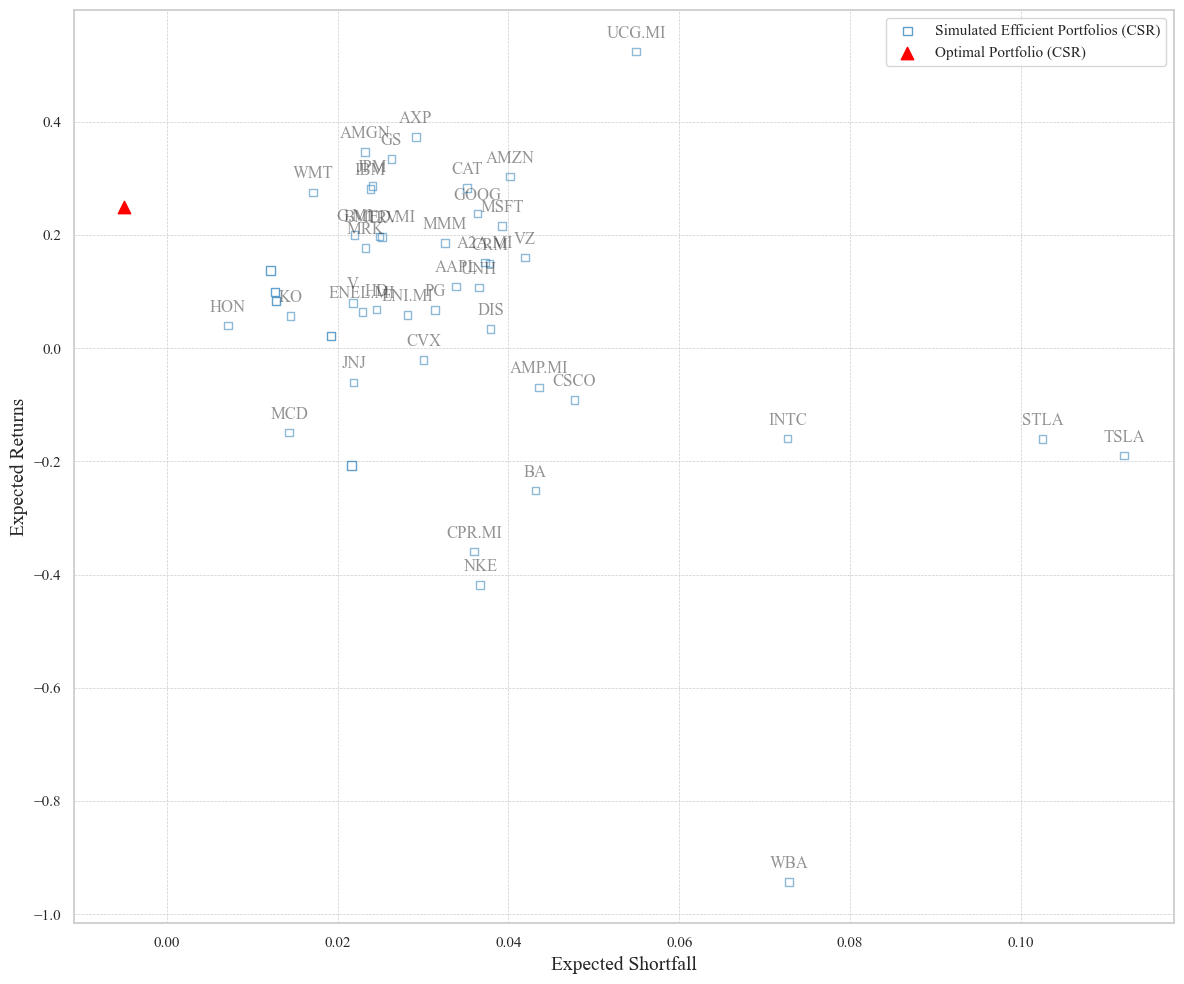

In [66]:
plt.rcParams['font.family'] = 'Times New Roman'

fig.patch.set_alpha(0)  
plt.figure(figsize=(12, 10))

#plt.scatter(expected_shortfall[::10],returns[::10],label = 'Original Efficient Portfolios',color='orange',s = 50,edgecolors='black')
plt.scatter(x[:-1], y[:-1], color='#1f77b4',  marker='s', label='Simulated Efficient Portfolios (CSR)', alpha=0.7,facecolor = 'none')
plt.scatter(x[-1], y[-1], color='red', marker='^', label='Optimal Portfolio (CSR)', s=80)
plt.scatter(x_assets, y_assets, color='#1f77b4', marker='s', s=30,alpha = 0.5,facecolor = 'none')
#plt.scatter(MV_S_P[1],MV_S_P[0],color = 'green', marker='s', s=50,alpha = 1,label='AVG Portfolio')
#plt.scatter(frontiera_efficiente[:,0],frontiera_efficiente[:,1],color='#1f77b4',  marker='s', alpha=0.7,facecolor = 'none')
#plt.scatter(rischi[::50],rendimenti_attesi[::50], color='#1f77b4', marker='s', s=30,alpha = 0.5,facecolor = 'none')
#plt.scatter(MV_S_P[1],MV_S_P[0],color = 'green', marker='s', s=50,alpha = 1,label='AVG Portfolio')
plt.xlabel('Expected Shortfall', fontsize=14)
plt.ylabel('Expected Returns', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc = 'best')
plt.axis('tight')

for i, txt in enumerate(ret_test.columns):
    plt.annotate(txt, (x_assets[i], y_assets[i]), textcoords="offset points", xytext=(0, 10), ha='center',alpha = 0.5)
#plt.savefig('BS_EF_vs_OEF.jpg', bbox_inches='tight', pad_inches=0)
#plt.savefig('BS_OVsS.JPG', format='jpg', transparent=True, bbox_inches='tight')

plt.tight_layout()

plt.show()

### Figure 12: Bootstrapped suboptimal portfolios: Expected Returns vs CSR

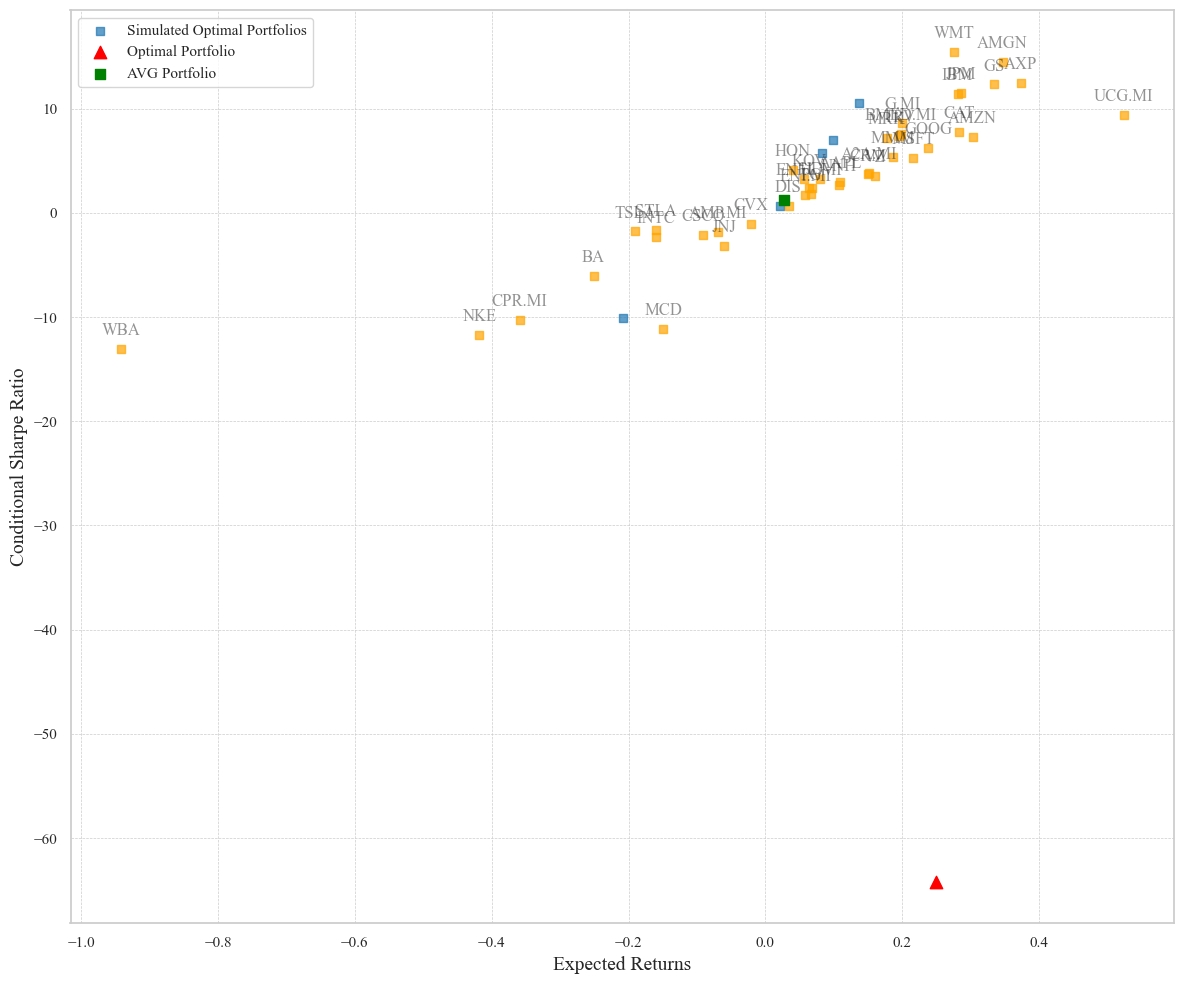

In [67]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(12, 10))

plt.scatter(y[:-1], z[:-1], color='#1f77b4', marker='s', label='Simulated Optimal Portfolios', alpha=0.7)
plt.scatter(y[-1], z[-1]-16, color='red', marker='^', label='Optimal Portfolio', s=80)
plt.scatter(y_assets, z_assets, color='orange', s=30, marker='s',alpha = 0.7)
plt.scatter(MV_S_P[0],((MV_S_P[0]- risk_free_rate)/MV_S_P[1]),color = 'green', marker='s', s=50,alpha = 1,label='AVG Portfolio')

plt.xlabel('Expected Returns', fontsize=14)
plt.ylabel('Conditional Sharpe Ratio', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
#plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc = 'upper left')

for i, txt in enumerate(ret_test.columns):
    plt.annotate(txt, (y_assets[i], z_assets[i]), textcoords="offset points", xytext=(0, 10), ha='center',alpha = 0.5)

plt.tight_layout()
#plt.savefig('BS_OVsS2.JPG', format='jpg')

plt.show()

### Figure 11: Optimal Weights Distribution

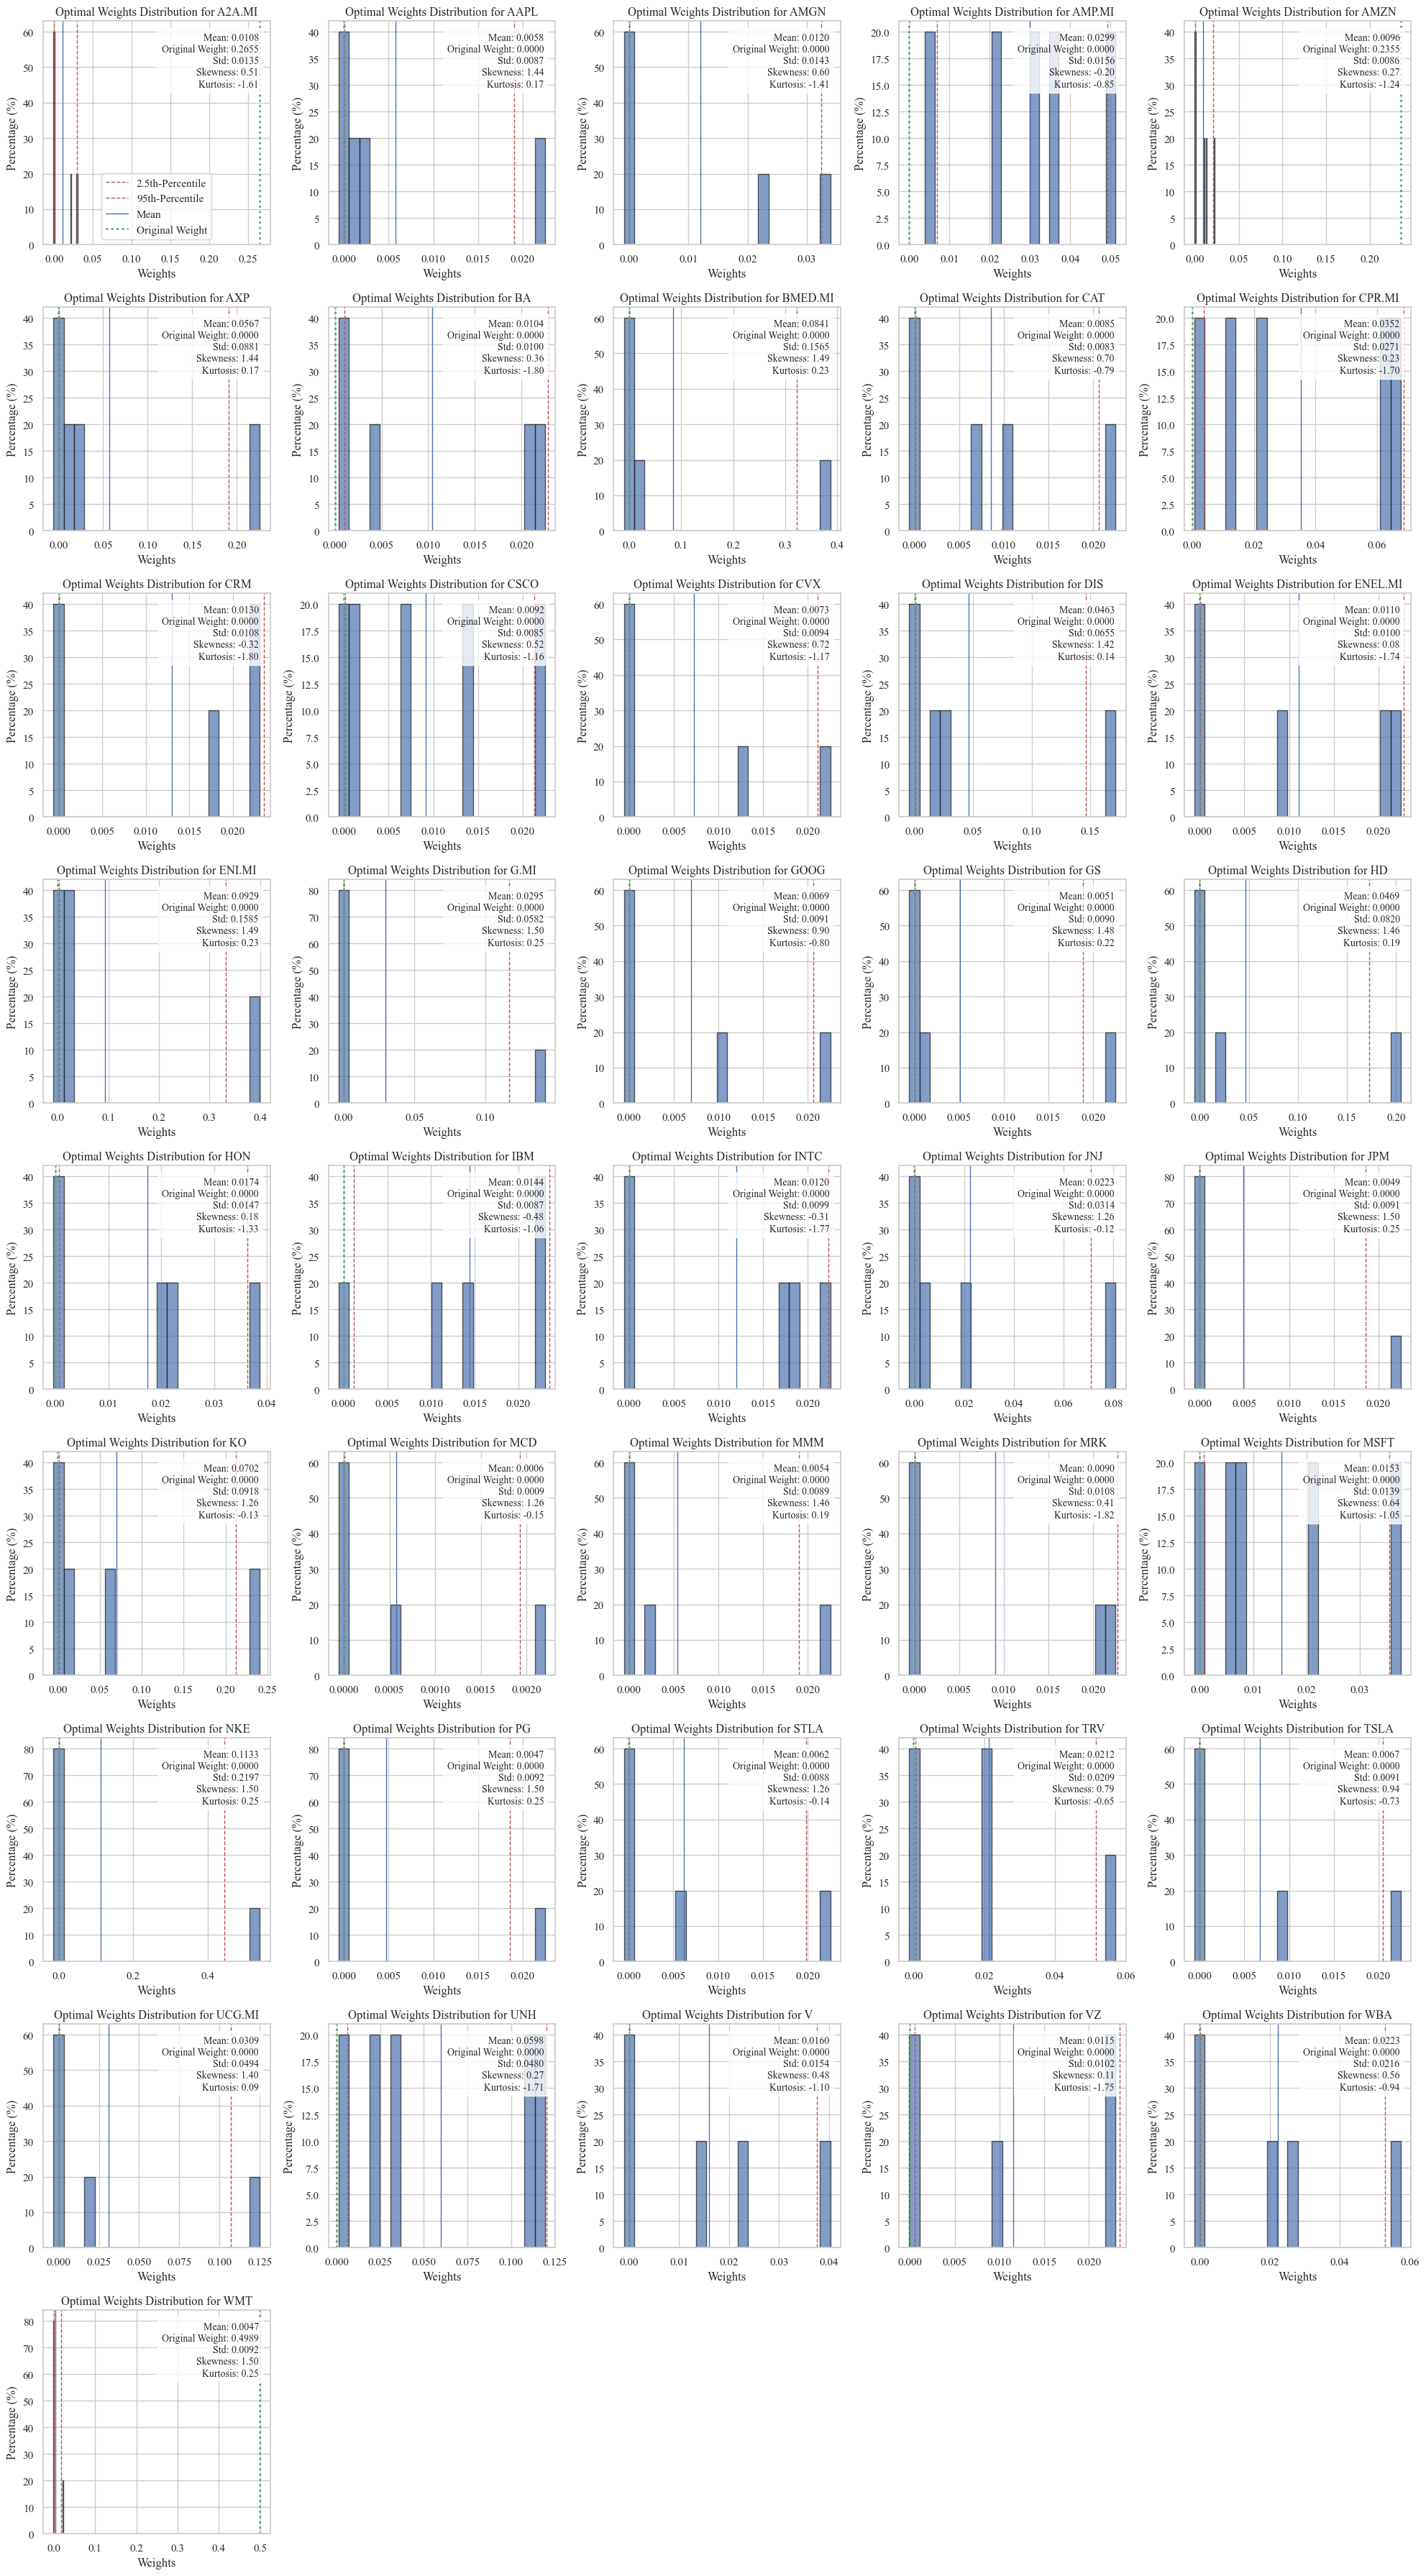

In [68]:
BS_SR = np.array(BS_SR)
n_cols = BS_SR.shape[1]
n_rows = (n_cols + 4) // 5  

fig, axs = plt.subplots(n_rows, 5, figsize=(20, 4 * n_rows))  # Crea n_rows x 5 subplot

for i in range(n_cols):
    chosen = BS_SR[:, i]
    lower_bound = np.percentile(chosen, 2.5)
    upper_bound = np.percentile(chosen, 95)
    mean_value = np.mean(chosen)
    std_value = np.std(chosen)  
    skewness = skew(chosen)  
    kurt = kurtosis(chosen)  
    original_weight = weights[0][i]  
    
    row = i // 5  
    col = i % 5  
    
    counts, bin_edges, _ = axs[row, col].hist(chosen, bins=20, edgecolor='k', alpha=0.7)


    total_count = np.sum(counts)
    percentages = (counts / total_count) * 100
    

    axs[row, col].clear()
    axs[row, col].bar(bin_edges[:-1], percentages, width=np.diff(bin_edges), edgecolor='k', alpha=0.7)
    
    axs[row, col].axvline(lower_bound, color='r', linestyle='dashed', linewidth=1, label='2.5th-Percentile')
    axs[row, col].axvline(upper_bound, color='r', linestyle='dashed', linewidth=1, label='95th-Percentile')
    axs[row, col].axvline(mean_value, color='b', linestyle='solid', linewidth=1, label='Mean')
    

    axs[row, col].axvline(original_weight, color='g', linestyle='dotted', linewidth=2, label='Original Weight')
    
    axs[row, col].set_ylabel('Percentage (%)')
    axs[row, col].set_title(f'Optimal Weights Distribution for {ret.columns[i]}')
    axs[row, col].set_xlabel('Weights')
    

    if i == 0:
        axs[row, col].legend()

    axs[row, col].text(0.95, 0.95, 
                       f'Mean: {mean_value:.4f}\n'
                       f'Original Weight: {original_weight:.4f}\n'
                       f'Std: {std_value:.4f}\n'
                       f'Skewness: {skewness:.2f}\n'
                       f'Kurtosis: {kurt:.2f}',
                       horizontalalignment='right', verticalalignment='top',
                       transform=axs[row, col].transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

for j in range(n_cols, n_rows * 5):
    fig.delaxes(axs[j // 5, j % 5])

plt.tight_layout()  
#plt.savefig('DQW.JPG', format='jpg', dpi=300)  # Salva il grafico in formato JPG ad alta risoluzione
plt.show()

## 4.4 - Rolling Window - Quarterly rebalance

In [97]:
def sliding_window_operation(R, H, G):
    """
    Splits a DataFrame into sub-DataFrames using a sliding window approach.

    Inputs:
    - R: DataFrame
        The original DataFrame to be split.
    - H: int
        The size of the first sliding window.
    - G: int
        The size of the second sliding window.

    Outputs:
    - H_dataframes: list of DataFrames
        A list containing the sub-DataFrames of size `H`.
    - G_dataframes: list of DataFrames
        A list containing the sub-DataFrames of size `G`.
    """
    H_dataframes = []
    G_dataframes = []
    a_final=[]
    b_final=[]
    c_final=[]
    
    i = 0  
    while i < len(R):

        end_H = min(i + H, len(R))
        H_df = R.iloc[i:end_H].copy()
        H_dataframes.append(H_df)

        a, b, c = NSGA_II(w, eta_mutation, upper, lower, crossover_probability, eta_crossover, probability_beta, p_m, number_of_generations, 1, H_df)
        a_final.append(a)
        b_final.append(b)
        c_final.append(c)

        if end_H < len(R):
            end_G = min(end_H + G, len(R))
            G_df = R.iloc[end_H:end_G].copy()
            G_dataframes.append(G_df)
        
        i += G
    
    return H_dataframes, G_dataframes, a_final,b_final,c_final

In [98]:
H_dataframes, G_dataframes, a_final,b_final,c_final = sliding_window_operation(R, H, G)

1
Elapsed time: 3.584962 seconds
2
Elapsed time: 6.008919 seconds
3
Elapsed time: 8.592815 seconds
1
Elapsed time: 3.637167 seconds
2
Elapsed time: 5.939110 seconds
3
Elapsed time: 8.216268 seconds
1
Elapsed time: 3.677556 seconds
2
Elapsed time: 6.241780 seconds
3
Elapsed time: 8.786864 seconds
1
Elapsed time: 3.708410 seconds
2
Elapsed time: 6.187899 seconds
3
Elapsed time: 8.749547 seconds
1
Elapsed time: 3.824769 seconds
2
Elapsed time: 6.387914 seconds
3
Elapsed time: 8.956044 seconds
1
Elapsed time: 3.869649 seconds
2
Elapsed time: 6.368963 seconds
3
Elapsed time: 8.891217 seconds
1
Elapsed time: 3.910648 seconds
2
Elapsed time: 6.239231 seconds
3
Elapsed time: 8.642285 seconds
1
Elapsed time: 3.638704 seconds
2
Elapsed time: 6.055115 seconds
3
Elapsed time: 8.405213 seconds
1
Elapsed time: 3.627014 seconds
2
Elapsed time: 6.046657 seconds
3
Elapsed time: 8.594489 seconds
1
Elapsed time: 3.939395 seconds
2
Elapsed time: 6.434721 seconds
3
Elapsed time: 8.927738 seconds


C:\Users\lollo\AppData\Local\Temp\ipykernel_46172\1844539982.py:55: RuntimeWarning: overflow encountered in exp
  term2 = np.exp(-((Y - prediction_0_05) * (quantile_0_05 - np.minimum(Y, prediction_0_05))) / (quantile_0_05 * (np.mean(Y) - ES_t_val)))
C:\Users\lollo\PycharmProjects\Dissertation\venv\lib\site-packages\scipy\optimize\_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
C:\Users\lollo\AppData\Local\Temp\ipykernel_46172\1844539982.py:55: RuntimeWarning: overflow encountered in exp
  term2 = np.exp(-((Y - prediction_0_05) * (quantile_0_05 - np.minimum(Y, prediction_0_05))) / (quantile_0_05 * (np.mean(Y) - ES_t_val)))
C:\Users\lollo\PycharmProjects\Dissertation\venv\lib\site-packages\scipy\optimize\_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


1
Elapsed time: 3.959311 seconds
2
Elapsed time: 6.576769 seconds
3
Elapsed time: 9.133929 seconds
1
Elapsed time: 3.822645 seconds
2
Elapsed time: 6.215832 seconds
3
Elapsed time: 8.691835 seconds
1
Elapsed time: 3.680484 seconds
2
Elapsed time: 6.039187 seconds
3
Elapsed time: 8.420595 seconds
1
Elapsed time: 3.653845 seconds
2
Elapsed time: 6.030393 seconds
3
Elapsed time: 8.489198 seconds
1
Elapsed time: 3.909152 seconds
2
Elapsed time: 6.372152 seconds
3
Elapsed time: 8.928067 seconds
1
Elapsed time: 3.827080 seconds
2
Elapsed time: 6.415711 seconds
3
Elapsed time: 8.975774 seconds
1
Elapsed time: 3.797228 seconds
2
Elapsed time: 6.293590 seconds
3
Elapsed time: 8.836350 seconds
1
Elapsed time: 3.734391 seconds
2
Elapsed time: 6.280076 seconds
3
Elapsed time: 8.922646 seconds
1
Elapsed time: 3.880005 seconds
2
Elapsed time: 6.302852 seconds
3
Elapsed time: 8.989101 seconds
1
Elapsed time: 3.759248 seconds
2
Elapsed time: 6.414151 seconds
3
Elapsed time: 9.020181 seconds
1
Elapsed 

C:\Users\lollo\AppData\Local\Temp\ipykernel_46172\1844539982.py:61: RuntimeWarning: invalid value encountered in log
  log_likelihood =( np.sum(np.log(likelihood)))
C:\Users\lollo\AppData\Local\Temp\ipykernel_46172\1844539982.py:61: RuntimeWarning: invalid value encountered in log
  log_likelihood =( np.sum(np.log(likelihood)))


1
Elapsed time: 4.002084 seconds
2
Elapsed time: 6.747011 seconds
3
Elapsed time: 9.212676 seconds
1
Elapsed time: 3.785374 seconds
2
Elapsed time: 6.269830 seconds
3
Elapsed time: 8.784860 seconds
1
Elapsed time: 3.657069 seconds
2
Elapsed time: 5.990884 seconds
3
Elapsed time: 8.538036 seconds
1
Elapsed time: 3.704213 seconds
2
Elapsed time: 6.430323 seconds
3
Elapsed time: 8.883163 seconds


C:\Users\lollo\AppData\Local\Temp\ipykernel_46172\1844539982.py:61: RuntimeWarning: invalid value encountered in log
  log_likelihood =( np.sum(np.log(likelihood)))
C:\Users\lollo\AppData\Local\Temp\ipykernel_46172\1844539982.py:61: RuntimeWarning: invalid value encountered in log
  log_likelihood =( np.sum(np.log(likelihood)))


1
Elapsed time: 3.556472 seconds
2
Elapsed time: 6.081671 seconds
3
Elapsed time: 8.479697 seconds
1
Elapsed time: 3.591110 seconds
2
Elapsed time: 6.035012 seconds
3
Elapsed time: 8.441578 seconds
1
Elapsed time: 3.266668 seconds
2
Elapsed time: 5.448397 seconds
3
Elapsed time: 7.636637 seconds
1
Elapsed time: 2.138844 seconds
2
Elapsed time: 3.512677 seconds
3
Elapsed time: 4.957026 seconds


C:\Users\lollo\AppData\Local\Temp\ipykernel_46172\1844539982.py:55: RuntimeWarning: overflow encountered in exp
  term2 = np.exp(-((Y - prediction_0_05) * (quantile_0_05 - np.minimum(Y, prediction_0_05))) / (quantile_0_05 * (np.mean(Y) - ES_t_val)))
C:\Users\lollo\PycharmProjects\Dissertation\venv\lib\site-packages\scipy\optimize\_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
C:\Users\lollo\AppData\Local\Temp\ipykernel_46172\1844539982.py:61: RuntimeWarning: invalid value encountered in log
  log_likelihood =( np.sum(np.log(likelihood)))
C:\Users\lollo\AppData\Local\Temp\ipykernel_46172\1844539982.py:61: RuntimeWarning: invalid value encountered in log
  log_likelihood =( np.sum(np.log(likelihood)))
C:\Users\lollo\AppData\Local\Temp\ipykernel_46172\1844539982.py:61: RuntimeWarning: invalid value encountered in log
  log_likelihood =( np.sum(np.log(likelihood)))
C:\Users\lollo\AppData\Local\Temp\ipykernel_46172\1844539982.py:61: RuntimeWarning

1
Elapsed time: 1.171832 seconds


C:\Users\lollo\AppData\Local\Temp\ipykernel_46172\1844539982.py:61: RuntimeWarning: invalid value encountered in log
  log_likelihood =( np.sum(np.log(likelihood)))
C:\Users\lollo\AppData\Local\Temp\ipykernel_46172\1844539982.py:61: RuntimeWarning: invalid value encountered in log
  log_likelihood =( np.sum(np.log(likelihood)))
C:\Users\lollo\AppData\Local\Temp\ipykernel_46172\1844539982.py:61: RuntimeWarning: invalid value encountered in log
  log_likelihood =( np.sum(np.log(likelihood)))


2
Elapsed time: 1.945183 seconds


C:\Users\lollo\AppData\Local\Temp\ipykernel_46172\1844539982.py:61: RuntimeWarning: invalid value encountered in log
  log_likelihood =( np.sum(np.log(likelihood)))
C:\Users\lollo\AppData\Local\Temp\ipykernel_46172\1844539982.py:61: RuntimeWarning: invalid value encountered in log
  log_likelihood =( np.sum(np.log(likelihood)))
C:\Users\lollo\AppData\Local\Temp\ipykernel_46172\1844539982.py:61: RuntimeWarning: invalid value encountered in log
  log_likelihood =( np.sum(np.log(likelihood)))
C:\Users\lollo\AppData\Local\Temp\ipykernel_46172\1844539982.py:61: RuntimeWarning: invalid value encountered in log
  log_likelihood =( np.sum(np.log(likelihood)))
C:\Users\lollo\AppData\Local\Temp\ipykernel_46172\1844539982.py:61: RuntimeWarning: invalid value encountered in log
  log_likelihood =( np.sum(np.log(likelihood)))


3
Elapsed time: 2.704896 seconds


In [99]:
c_final = c_final[:len(G_dataframes)]
b_final = b_final[:len(G_dataframes)]
a_final = a_final[:len(G_dataframes)]

In [100]:
def calculate_sharpe_ratio(returns, risk_free_rate, expected_shortfall):
    return (returns - risk_free_rate) / expected_shortfall

results_indices = []
w_max_sharpe_list = []
w_max_return_list = []
w_min_expected_shortfall_list = []
w_max_area_list = []
for window in b_final:
    costs = []
    for sublist in window:
        for entry in sublist:
            costs.append(entry['cost'])
    costs_array = np.array(costs)


    returns = costs_array[:, 0]
    expected_shortfall = costs_array[:, 1]

    sharpe_ratios = calculate_sharpe_ratio(returns, risk_free_rate, expected_shortfall)

    max_sharpe_index = np.argmax(sharpe_ratios)
    max_return_index = np.argmax(returns)
    min_expected_shortfall_index = np.argmin(expected_shortfall)

    results_indices.append({
        "max_sharpe_index": max_sharpe_index,
        "max_return_index": max_return_index,
        "min_expected_shortfall_index": min_expected_shortfall_index
    })

    sorted_indices = np.argsort(returns)
    sorted_costs_array = costs_array[sorted_indices]

    reference = np.array([np.min(returns), np.max(expected_shortfall)])

    aree = []
    for i in range(len(sorted_costs_array[:, 0])):
        base = np.abs(reference[0] - sorted_costs_array[i, 0])
        altezza = np.abs(reference[1] - sorted_costs_array[i, 1])
        area = base * altezza
        aree.append(area)

    max_area_index = sorted_indices[np.argmax(aree)]

    flattened_arrays = [np.array(arr).flatten() for arr in c_final]
    combined_array = np.concatenate(flattened_arrays)
    w_opt = combined_array.reshape(-1, len(ret_train.T))

    w_max_sharpe = w_opt[max_sharpe_index]
    w_max_return = w_opt[max_return_index]
    w_min_expected_shortfall = w_opt[min_expected_shortfall_index]
    w_max_area = w_opt[max_area_index]

    w_max_sharpe_list.append(w_max_sharpe)
    w_max_return_list.append(w_max_return)
    w_min_expected_shortfall_list.append(w_min_expected_shortfall)
    w_max_area_list.append(w_max_area)

w_max_sharpe_array = np.array(w_max_sharpe_list)
w_max_return_array = np.array(w_max_return_list)
w_min_expected_shortfall_array = np.array(w_min_expected_shortfall_list)
w_max_area_array = np.array(w_max_area_list)
EW = np.full(w_max_area_array.shape, 1/len(ret.T))

In [88]:
R = ret
H = 21*12
G = 21*4
H_dataframes, G_dataframes = sliding_window_operation(R, H, G)

In [101]:
def rebalance_portfolio(df_test, ret_test, weights_array, rebalance_frequency_days=1000):
    """
    Rebalances a portfolio periodically based on the provided weight array and rebalancing frequency.

    Inputs:
    - df_test: DataFrame
        The dataframe containing the price data for assets.
    - ret_test: DataFrame
        The dataframe containing the returns data for assets.
    - weights_array: list of lists
        A list where each element is a list representing the portfolio weights for a given rebalancing period.
    - rebalance_frequency_days: int, optional
        The frequency in days at which the portfolio should be rebalanced (default is 1000 days).

    Outputs:
    - results: list of Series
        A list containing the portfolio values over time.
    - rebalancing_dates: list of bool
        A list indicating whether rebalancing occurred on each day (True) or not (False).
    - df_test_copy: DataFrame
        A copy of df_test with additional columns for portfolio value, asset shares, and asset values.
    """
    results = []
    rebalancing_dates = []

    current_window = 0
    df_test_copy = df_test.copy()
    new_indexes = pd.date_range(start=ret_test.index[0], periods=len(ret_test), freq='B')
    df_test_copy.index = new_indexes
    

    portfolio_value = 1
    shares_df = pd.DataFrame(index=df_test_copy.index, columns=[s + '_shares' for s in ret_test.columns])
    prev_values = None
    
    for i, day in enumerate(df_test_copy.index):
        if current_window < len(weights_array):
            weights_reb = weights_array[current_window]

        if i % rebalance_frequency_days == 0:
            if prev_values is not None:
                current_window += 1
                if current_window < len(weights_array):
                    weights_reb = weights_array[current_window] 
            
            new_shares = [(portfolio_value * w) / df_test_copy[s][day] for s, w in zip(ret_test.columns, weights_reb)]
            shares_df.loc[day] = new_shares
            prev_values = shares_df.loc[day].to_dict()
            rebalancing_dates.append(True)
        else:
            shares_df.loc[day] = [prev_values.get(s + '_shares', np.nan) for s in ret_test.columns]
            rebalancing_dates.append(False)

        asset_values = [shares_df.loc[day, s + '_shares'] * df_test_copy.loc[day, s] for s in ret_test.columns]
        portfolio_value = sum(asset_values)

        df_test_copy.loc[day, 'Portfolio_Value'] = portfolio_value
        for s in ret_test.columns:
            df_test_copy.loc[day, s + '_shares'] = shares_df.loc[day, s + '_shares']
            df_test_copy.loc[day, s + '_value'] = shares_df.loc[day, s + '_shares'] * df_test_copy.loc[day, s]
    results.append(df_test_copy['Portfolio_Value'])

    return results, rebalancing_dates, df_test_copy

In [102]:
G = pd.concat(G_dataframes)
df_test_1 = df_test[len(df_test)-len(G):]

In [103]:
res_w_max_sharpe,reb_d,cop_max_CSR=rebalance_portfolio(df_test_1, G, w_max_sharpe_array, rebalance_frequency_days=21*4)
res_w_min_ES,reb_d,cop_min_ES=rebalance_portfolio(df_test_1, G, w_min_expected_shortfall_array, rebalance_frequency_days=21*4)
res_w_max_area,reb_d,cop_max_area=rebalance_portfolio(df_test_1, G, w_max_area_array, rebalance_frequency_days=21*4)
res_w_max_ret,reb_d,cop_max_ret=rebalance_portfolio(df_test_1, G, w_max_return_array, rebalance_frequency_days=21*4)
res_w_EW,reb_d,cop_EW=rebalance_portfolio(df_test_1, G, EW, rebalance_frequency_days=21*4)

### Figure 9: Cumulative returns

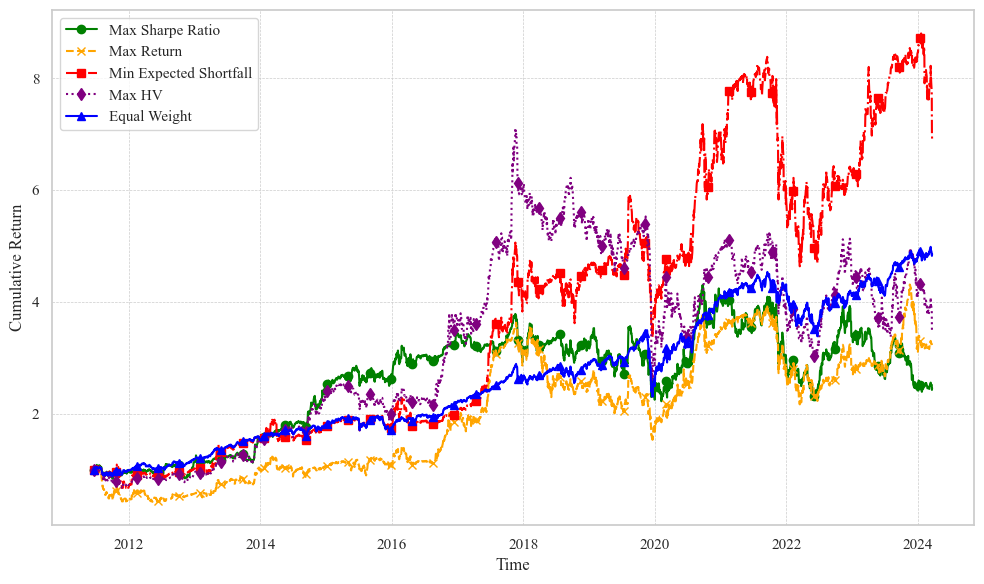

In [104]:
plt.figure(figsize=(10, 6))
plt.rcParams['font.family'] = 'Times New Roman'
plt.plot(pd.DataFrame(res_w_max_sharpe).T, label='Max Sharpe Ratio', linestyle='-', marker='o', markevery=(21*4),color = 'green')
plt.plot(pd.DataFrame(res_w_max_ret).T, label='Max Return', linestyle='--', marker='x', markevery=(21*4),color = 'orange')
plt.plot(pd.DataFrame(res_w_min_ES).T, label='Min Expected Shortfall', linestyle='-.', marker='s', markevery=(21*4),color = 'red')
plt.plot(pd.DataFrame(res_w_max_area).T, label='Max HV', linestyle=':', marker='d', markevery=(21*4),color = 'purple')
plt.plot(pd.DataFrame(res_w_EW).T, label='Equal Weight', linestyle='-', marker='^', markevery=(21*4),color = 'blue')
plt.xlabel('Time')
plt.ylabel('Cumulative Return')


plt.legend(loc='best')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
#plt.savefig('RW_TT.JPG', format='jpg')
plt.show()

In [105]:
columns_shares = cop_max_CSR.filter(regex='_value$')

### Figure 13: Rolling Window, Stocks Values Over Time of Max CSR Portfolio

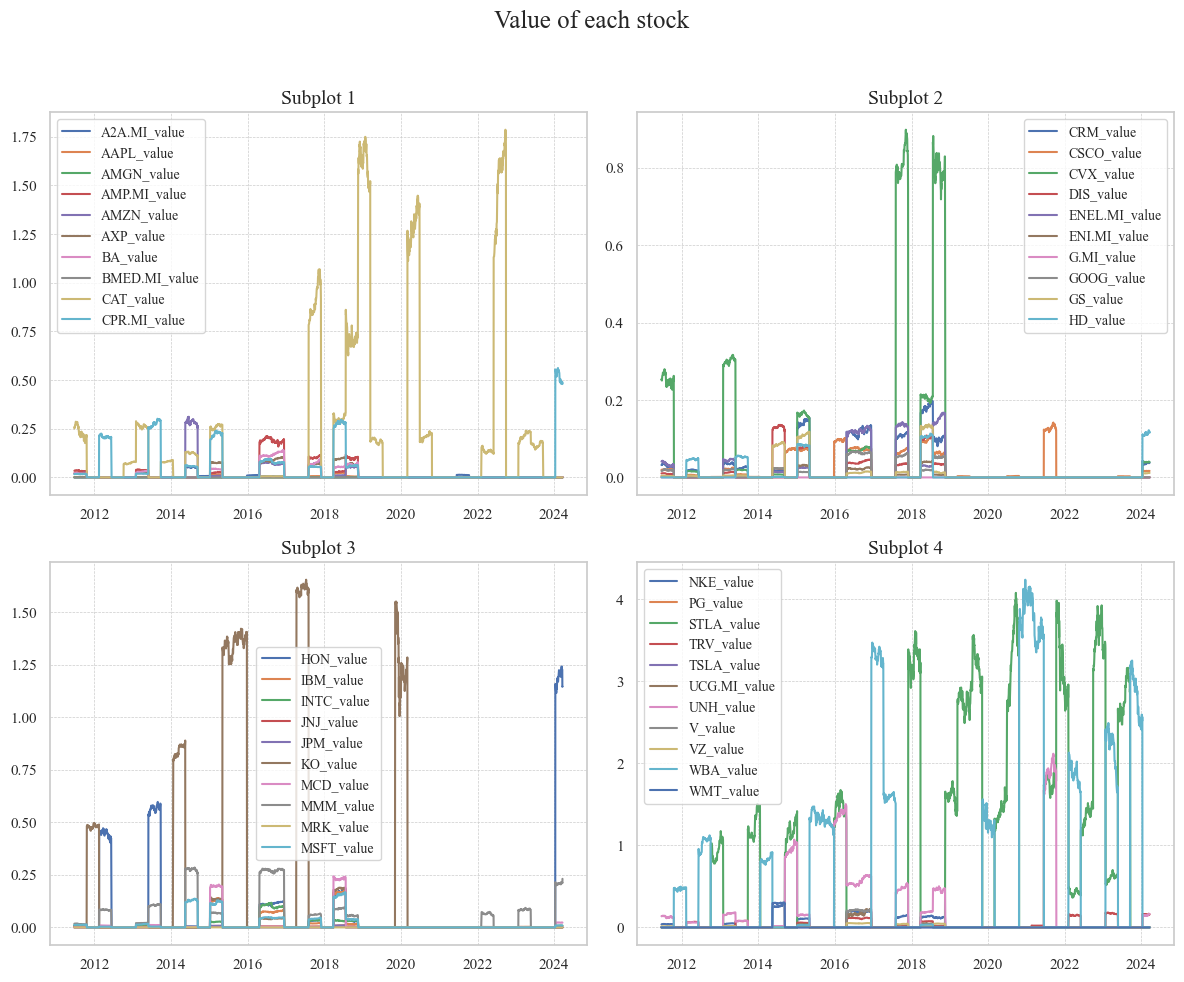

In [106]:
plt.figure(figsize=(12, 10))

total_columns = len(columns_shares.columns)

n_subplots = 4

for i in range(n_subplots):
    plt.subplot(2, 2, i + 1) 
    start_col = i * 10
    end_col = start_col + 10 if i < n_subplots - 1 else total_columns
    
    for column in columns_shares.columns[start_col:end_col]:
        plt.plot(columns_shares.index, columns_shares[column], label=column)
    plt.title(f'Subplot {i + 1}', fontsize=14)
    plt.legend(fontsize=10, loc='best')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.suptitle('Value of each stock', fontsize=18)
#plt.savefig('Value_OT.JPG', format='jpg')

plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

### Table 2: Performance Metrics of Different Strategies

In [107]:
def ret_extraction(res_w_max_sharpe):
    rey = np.array(res_w_max_sharpe).copy()
    rey = np.diff(res_w_max_sharpe)
    rey = rey[0]
    return rey

In [110]:
def MDD(res_w_min_ES):
    return(np.max(ret_extraction(res_w_min_ES))-np.min(ret_extraction(res_w_min_ES)))/(np.max(ret_extraction(res_w_min_ES)))

In [111]:
def Weights_Difference(weights):
    difference = []
    for j in range(len(weights) - 1):
        for i in range(len(weights[j])):
            current_w = weights[j][i]
            #print(current_w)
            next_w = weights[j+1][i]
            #print(next_w)
            difference.append((next_w - current_w) ** 2)
            #print('NExt')

    if not difference:
        raise ValueError("Nessuna differenza calcolabile. Controlla la lunghezza degli array.")

    average_difference = sum(difference) / len(difference)
    return average_difference
disp = pd.DataFrame([Weights_Difference(w_max_sharpe_array),
              Weights_Difference(w_min_expected_shortfall_array),
              Weights_Difference(w_max_area_array),
              Weights_Difference(w_max_return_array),
              Weights_Difference(EW),
             
             ] ,
             index = ['Max Sharpe','Min ES','Max Area','Max Return','EW'],
            columns = ['CR_t'])
disp['Ann Std Dev'] = [np.std(ret_extraction(res_w_max_sharpe),axis = 0),
    np.std(ret_extraction(res_w_min_ES),axis = 0),
    np.std(ret_extraction(res_w_max_area),axis = 0),
    np.std(ret_extraction(res_w_max_ret),axis = 0),
    np.std(ret_extraction(res_w_EW),axis = 0),]
disp['Ann Avg'] = [np.mean(ret_extraction(res_w_max_sharpe),axis = 0)*252,
    np.mean(ret_extraction(res_w_min_ES),axis = 0)*252,
    np.mean(ret_extraction(res_w_max_area),axis = 0)*252,
    np.mean(ret_extraction(res_w_max_ret),axis = 0)*252,
    np.mean(ret_extraction(res_w_EW),axis = 0)*252,]

disp['Maximum Drawdown']= [MDD(res_w_max_sharpe),
                           MDD(res_w_min_ES),
                           MDD(res_w_max_area),
                           MDD(res_w_max_ret),
                           MDD(res_w_EW)]
disp['Ann Std Dev']  = disp['Ann Std Dev'] *np.sqrt(252)

In [112]:
disp

,CR_t,Ann Std Dev,Ann Avg,Maximum Drawdown
Max Sharpe,0.0200,0.7351,0.1107,2.4753
Min ES,0.0140,1.2162,0.4473,2.4753
Max Area,0.0161,1.0583,0.1867,2.4961
Max Return,0.0140,0.6868,0.1707,2.4365
EW,0.0000,0.4254,0.2925,2.4389
